# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 02.02.2024

Мягкий дедлайн: 23:59MSK 26.02.2024

Жесткий дедлайн: 23:59MSK 09.03.2024

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: xx.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [1]:
!pip install folium

In [2]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import sklearn.model_selection
import sklearn.linear_model

%matplotlib inline
%config InlineBackend.figure_format = "retina"

plt.rcParams["figure.figsize"] = (8.0, 5.0)
plt.rcParams["font.size"] = 12
sns.set(style="darkgrid")

np.random.seed(0)

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [4]:
# !wget -O train.csv 'https://firebasestorage.googleapis.com/v0/b/test-bbb2d.appspot.com/o/train.csv?alt=media&token=505676d4-dad3-43ac-bc96-643776d68b06'

In [5]:
df0 = pd.read_csv("train.csv")
df0.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [6]:
df1 = df0.drop(columns="dropoff_datetime").assign(pickup_datetime=pd.to_datetime(df0["pickup_datetime"]))
df1.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435


В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

14593 trips with duration >= 3440.0 excluded from the histogram as outliers


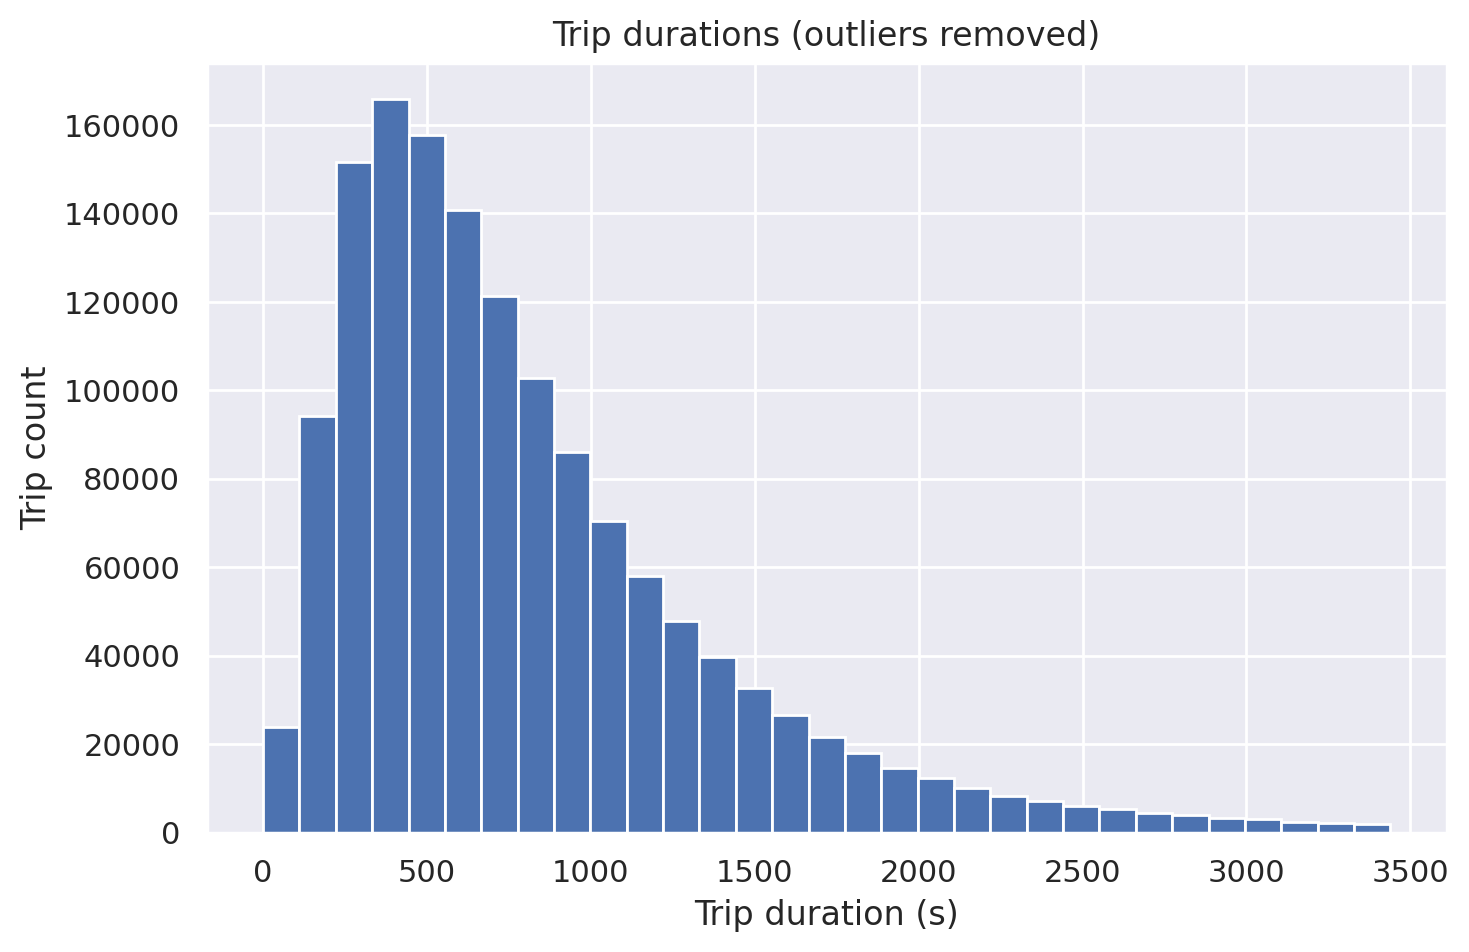

In [7]:
trip_duration_th = np.quantile(df1["trip_duration"], 0.99)
print(f"{(df1['trip_duration'] >= trip_duration_th).sum()} trips with duration >= {trip_duration_th} excluded from the histogram as outliers")
plt.hist(df1[df1["trip_duration"] < trip_duration_th]["trip_duration"], bins="doane")
plt.xlabel("Trip duration (s)")
plt.ylabel("Trip count")
plt.title("Trip durations (outliers removed)")
plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

**Ответ**: целевая переменная имеет унимодальное логнормальное распределение с модой ~450 секунд; 99% наблюдений целевой переменной попадают в диапазон 0-3500 секунд; некоторые из оставшихся 1% наблюдений выходят очень далеко за рамки этого диапазона.

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

**Ответ**: значения целевой переменной, из-за логнормального распределения, покрывают очень широкий диапазон; метрика RMSE измеряет среднюю абсолютную ошибку,
поэтому при ее использовании ошибки в предсказании больших значений целевой переменной могут сильно влиять на точность предсказаний малых значений
(а таких подавляющее большинство); метрика RMSLE измеряет среднюю относительную ошибку, поэтому она больше подходит для данных с большим разбросом значений.

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**:
$$
\begin{aligned}
  \mathrm{RMSLE}(X, y, a)
  &= \sqrt{\frac{1}{\ell}\sum_{i = 1}^{\ell}\left(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\right)^2}
  = \sqrt{\frac{1}{\ell}\sum_{i = 1}^{\ell}\left(\hat{y}_i - \log{(a(x_i) + 1)}\right)^2} = \\
  &= \sqrt{\frac{1}{\ell}\sum_{i = 1}^{\ell}\left(\hat{y}_i - \log{(\exp{(\hat{a}(x_i))} - 1 + 1)}\right)^2}
  = \sqrt{\frac{1}{\ell}\sum_{i = 1}^{\ell}\left(\hat{y}_i - \log{(\exp{(\hat{a}(x_i))})}\right)^2}
  = \sqrt{\frac{1}{\ell}\sum_{i = 1}^{\ell}\left(\hat{y}_i - \hat{a}(x_i)\right)^2} = \\
  &= \mathrm{RMSE}(X, \hat{y}, \hat{a}) = \sqrt{\mathrm{MSE}(X, \hat{y}, \hat{a})}
\end{aligned}
$$

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

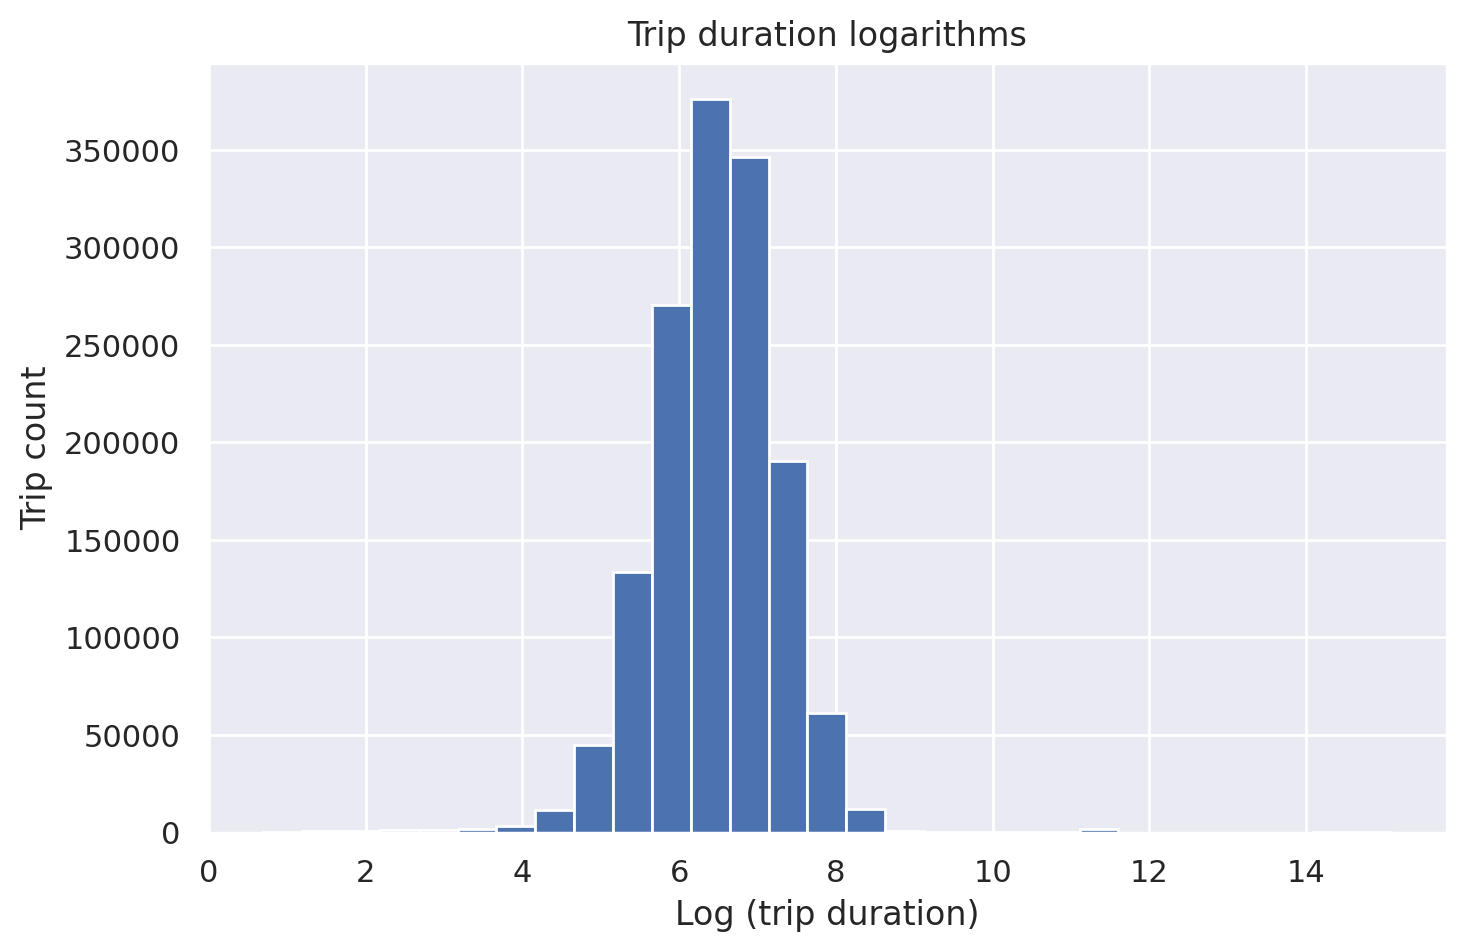

In [8]:
df2 = df1.drop(columns="trip_duration").assign(log_trip_duration=np.log1p(df1["trip_duration"]))
plt.hist(df2["log_trip_duration"], bins="doane")
plt.xlabel("Log (trip duration)")
plt.ylabel("Trip count")
plt.title("Trip duration logarithms")
plt.show()

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [9]:
def rmsle(log1p_y_true, log1p_y_pred): 
    return np.sqrt(np.mean(np.square(log1p_y_true - log1p_y_pred)))

rmsle_best_const = rmsle(df2["log_trip_duration"], np.mean(df2["log_trip_duration"]))
print(rmsle_best_const)
assert np.allclose(rmsle_best_const, 0.79575, 1e-4)

0.7957592365411509


## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

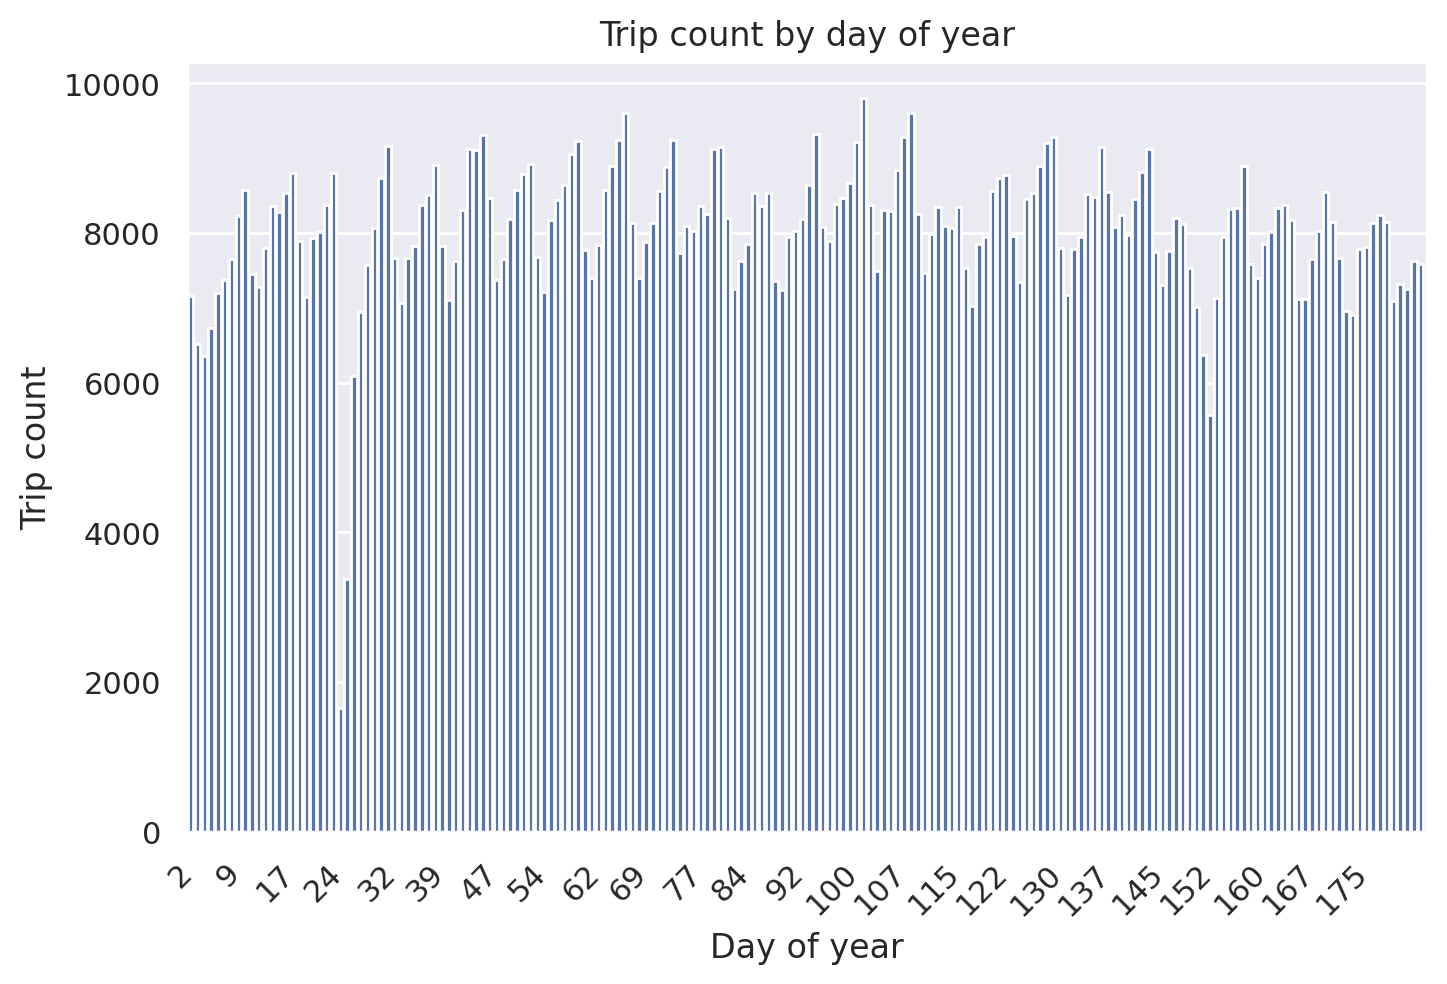

In [10]:
sns.countplot(x=df2["pickup_datetime"].dt.dayofyear)
plt.xticks(np.linspace(df2["pickup_datetime"].dt.dayofyear.min(), df2["pickup_datetime"].dt.dayofyear.max(), 25).astype(int), rotation=45, ha="right")
plt.xlabel("Day of year")
plt.ylabel("Trip count")
plt.title("Trip count by day of year")
plt.show()

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

**Ответ**:
- **23-24 января 2016**: ограничения на передвижение транспорта из-за сильной метели
- **29-30 мая 2016**: дождь в количестве 42 мм в результате тропического циклона Бонни

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

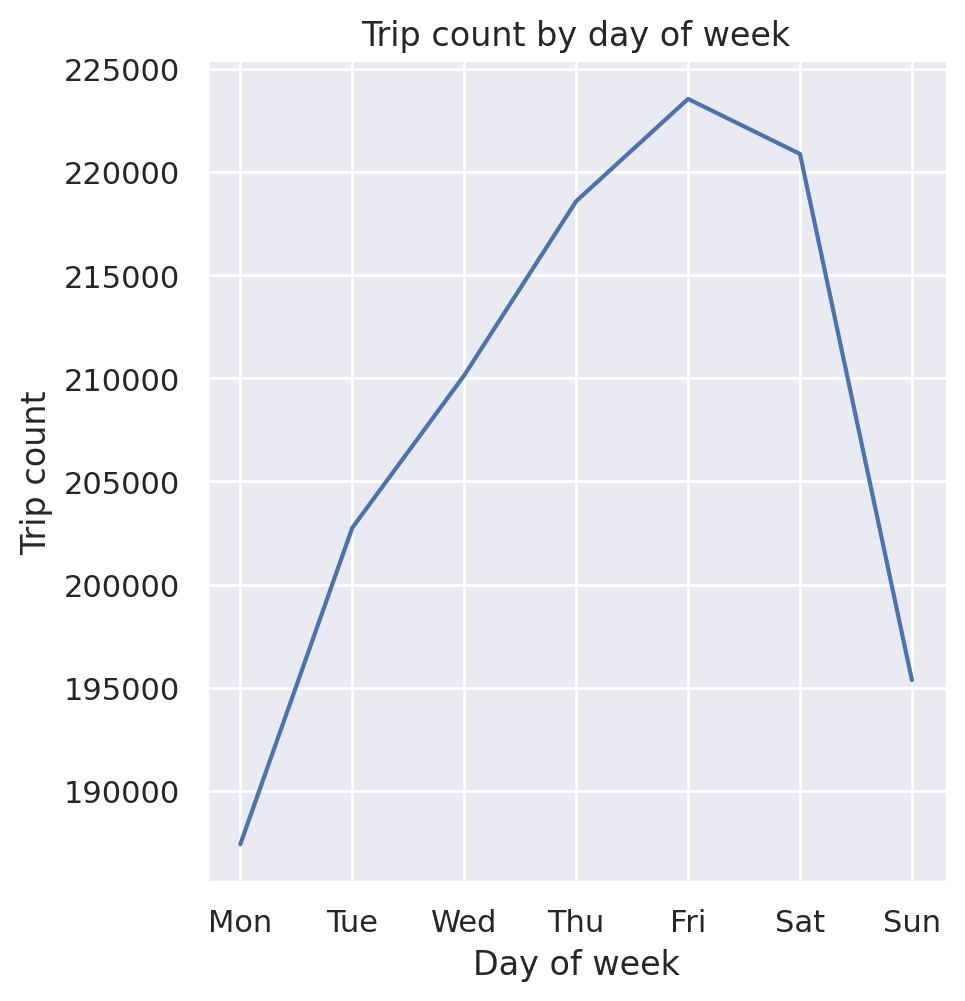

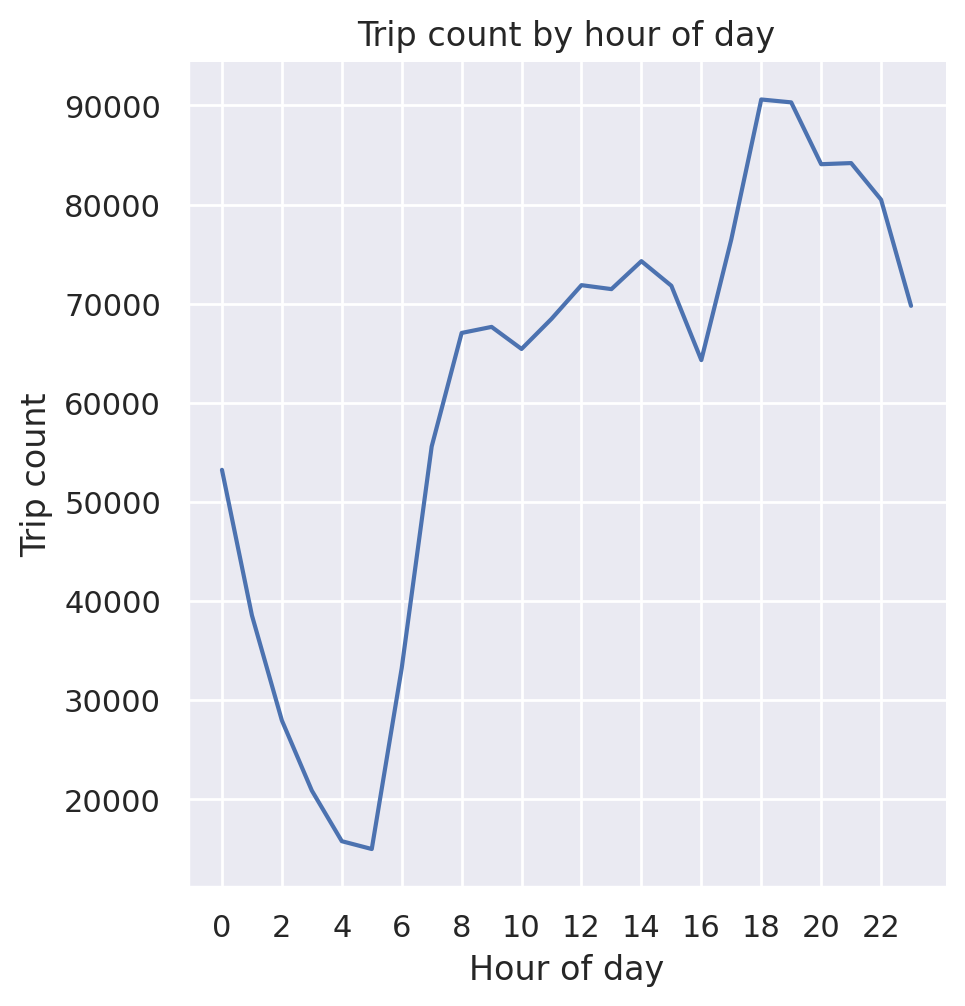

In [11]:
sns.relplot(df2["pickup_datetime"].dt.dayofweek.value_counts(), kind="line")
plt.xticks(np.arange(0, 7), ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.xlabel("Day of week")
plt.ylabel("Trip count")
plt.title("Trip count by day of week")
plt.show()

sns.relplot(df2["pickup_datetime"].dt.hour.value_counts(), kind="line")
plt.xticks(np.arange(0, 24, 2))
plt.xlabel("Hour of day")
plt.ylabel("Trip count")
plt.title("Trip count by hour of day")
plt.show()

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

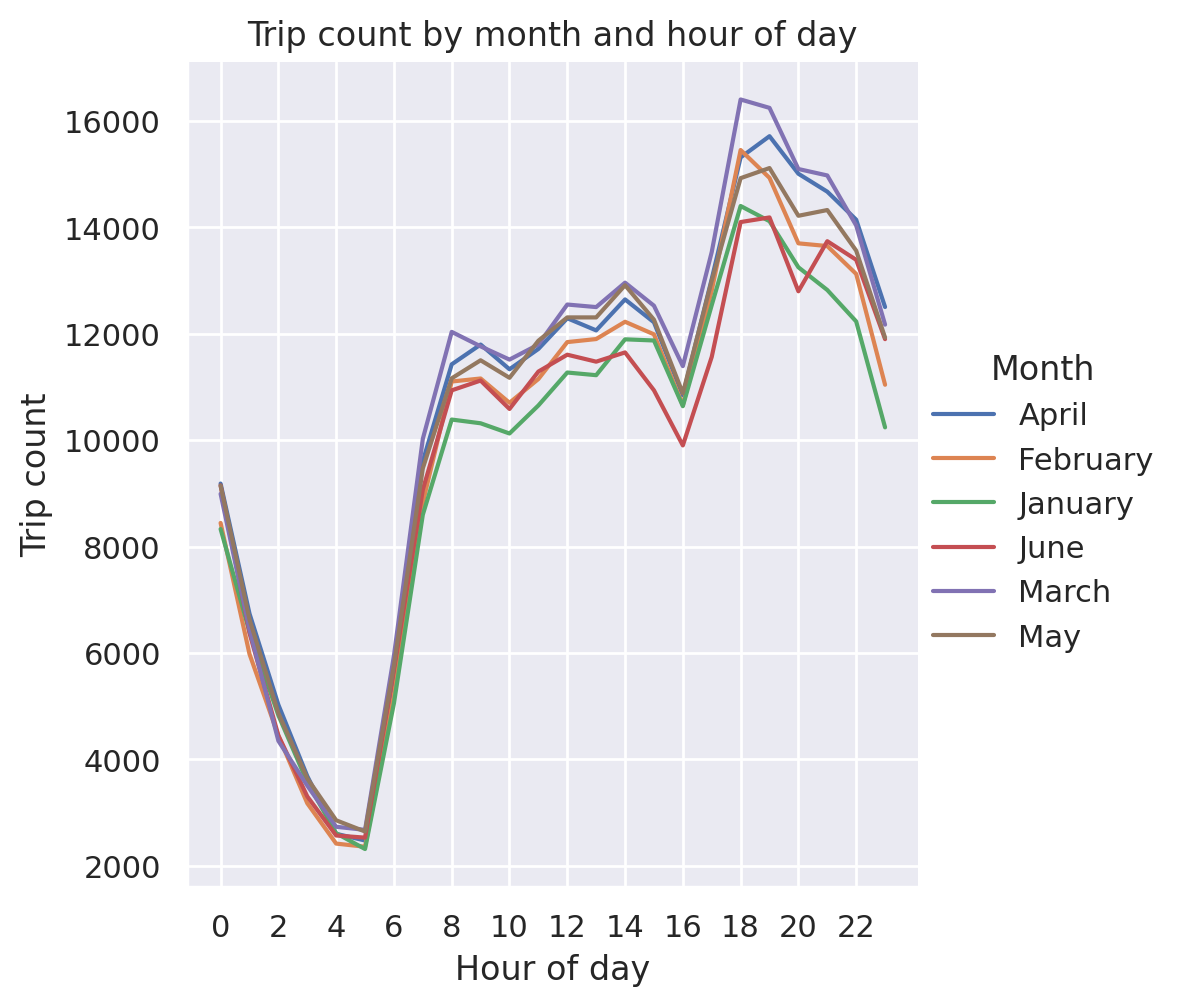

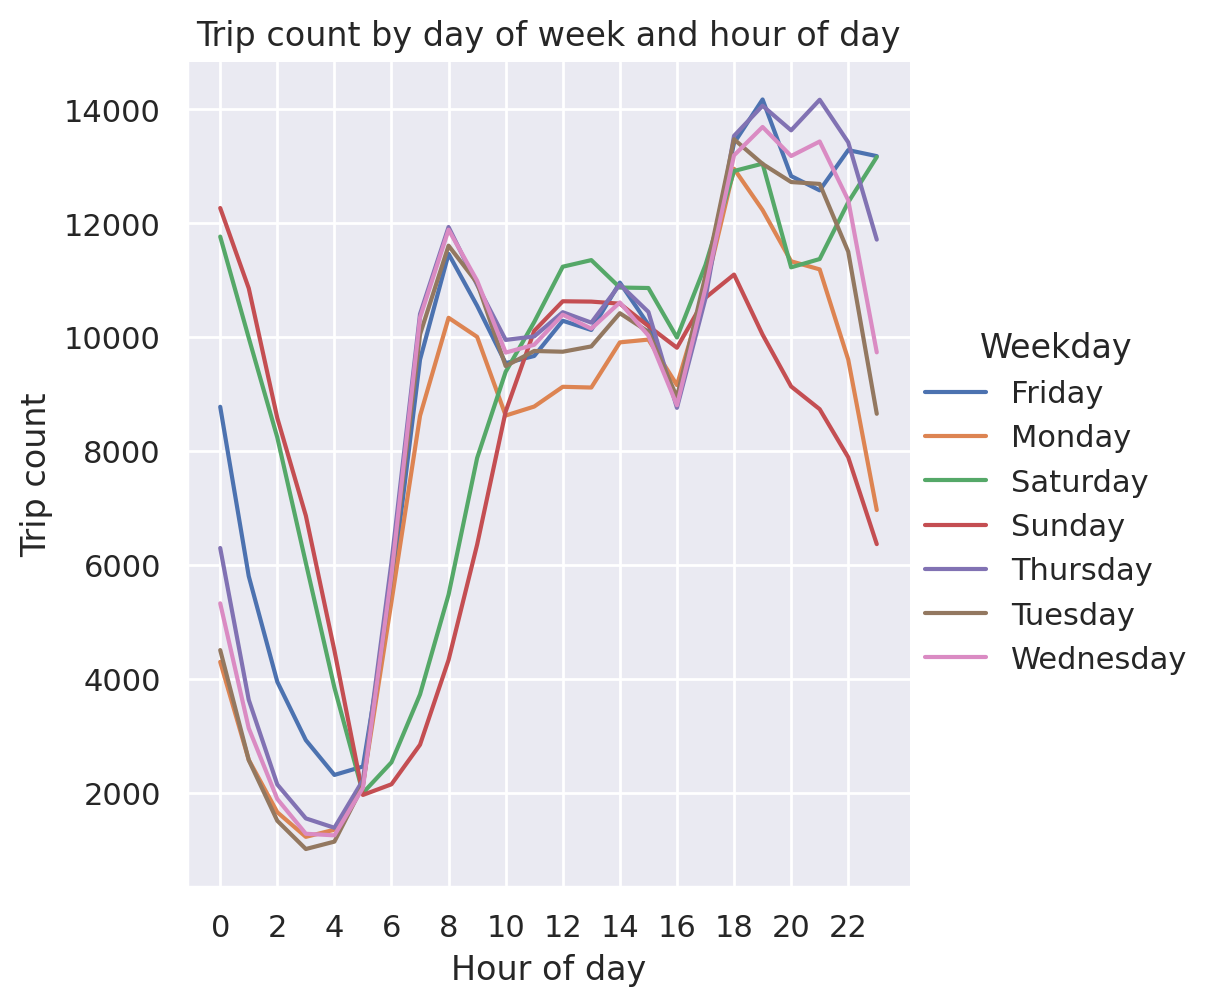

In [12]:
tmp = df2.assign(Month=df2["pickup_datetime"].dt.month_name(), hour=df2["pickup_datetime"].dt.hour).groupby("Month")["hour"].value_counts()
tmp = tmp.index.to_frame().assign(count=tmp)
sns.relplot(tmp, x="hour", y="count", hue="Month", kind="line")
plt.xticks(np.arange(0, 24, 2))
plt.xlabel("Hour of day")
plt.ylabel("Trip count")
plt.title("Trip count by month and hour of day")
plt.show()

tmp = df2.assign(Weekday=df2["pickup_datetime"].dt.day_name(), hour=df2["pickup_datetime"].dt.hour).groupby("Weekday")["hour"].value_counts()
tmp = tmp.index.to_frame().assign(count=tmp)
sns.relplot(tmp, x="hour", y="count", hue="Weekday", kind="line")
plt.xticks(np.arange(0, 24, 2))
plt.xlabel("Hour of day")
plt.ylabel("Trip count")
plt.title("Trip count by day of week and hour of day")
plt.show()

del tmp

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Ответ**:
- ни один месяц особо не выделятся на фоне остальных
- активность падает в ночное время &mdash; примерно между 22 и 6 часами
- два основных пика активности &mdash; 8 часов (люди едут на работу) и 18 часов (люди возвращаются с работы)
- в выходные минимум (и соответственно начало роста) активности сдвигается вперед примерно на 2 часа (люди ложатся спать и просыпаются позже)
- стоит также отметить высокую активность около 0 часов по выходным (люди возвращаются из баров/клубов/etc)

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3 (используйте `train_test_split` из `sklearn`). По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

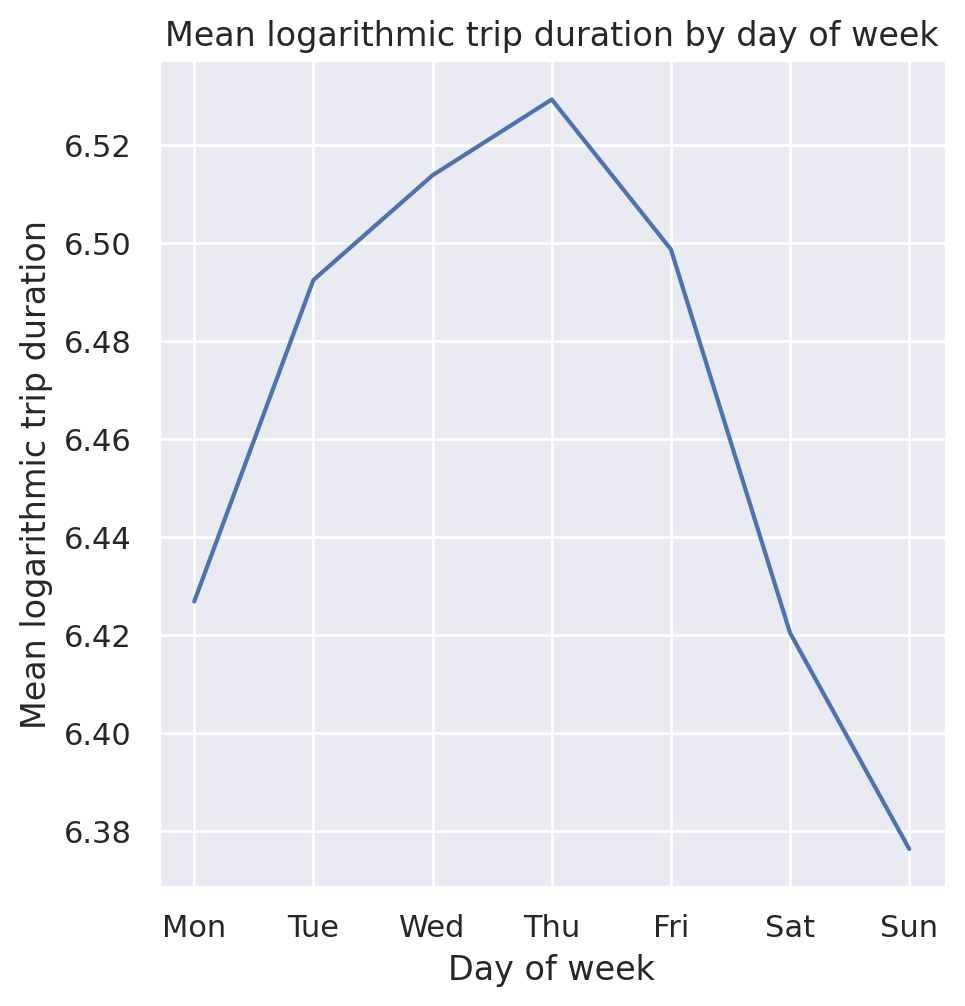

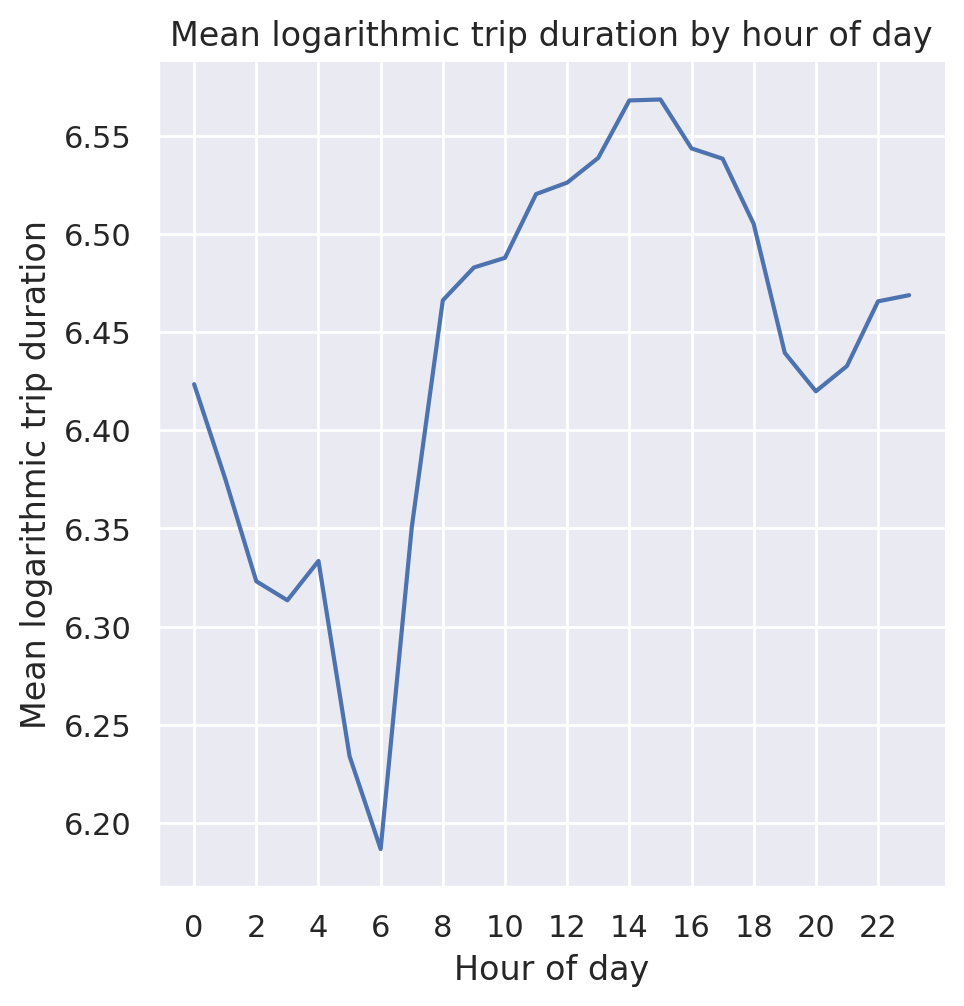

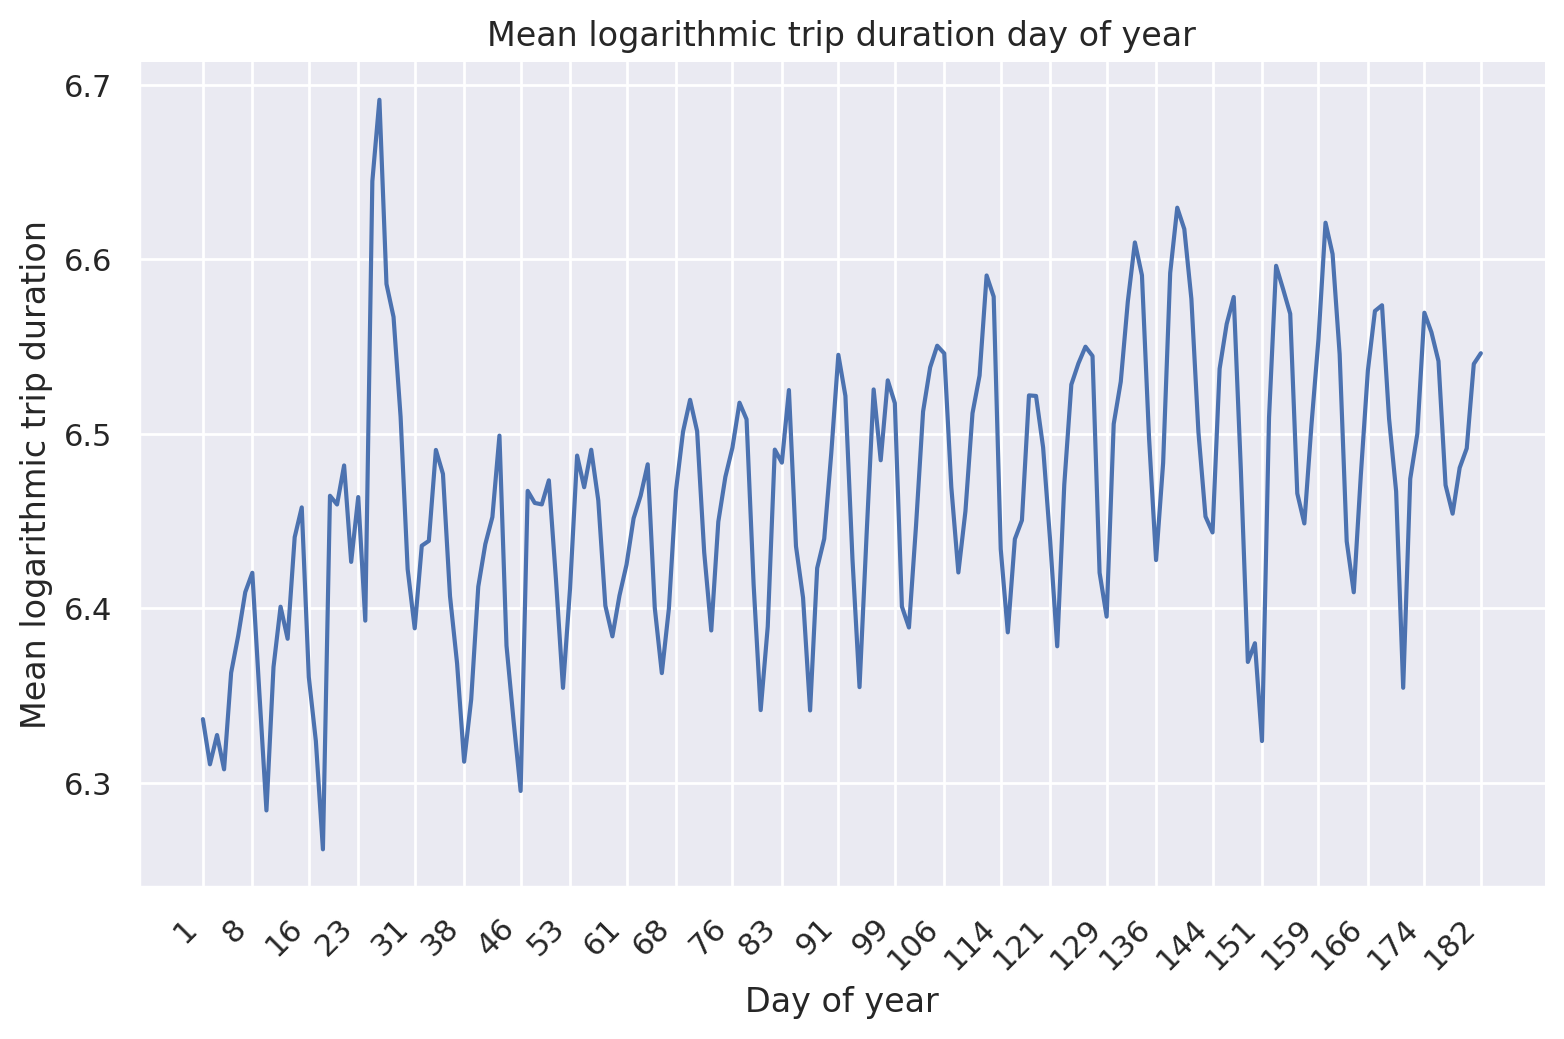

In [13]:
df2_train, df2_test = sklearn.model_selection.train_test_split(df2, train_size=0.7, test_size=0.3, random_state=42)
itr0 = df2_train.index
ite0 = df2_test.index

sns.relplot(df2_train.groupby(df2_train["pickup_datetime"].dt.dayofweek)["log_trip_duration"].mean(), kind="line")
plt.xticks(np.arange(0, 7), ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.xlabel("Day of week")
plt.ylabel("Mean logarithmic trip duration")
plt.title("Mean logarithmic trip duration by day of week")
plt.show()

sns.relplot(df2_train.groupby(df2_train["pickup_datetime"].dt.hour)["log_trip_duration"].mean(), kind="line")
plt.xticks(np.arange(0, 24, 2))
plt.xlabel("Hour of day")
plt.ylabel("Mean logarithmic trip duration")
plt.title("Mean logarithmic trip duration by hour of day")
plt.show()

sns.relplot(df2_train.groupby(df2_train["pickup_datetime"].dt.dayofyear)["log_trip_duration"].mean(), kind="line", height=5, aspect=8/5)
plt.xticks(np.linspace(df2["pickup_datetime"].dt.dayofyear.min(), df2["pickup_datetime"].dt.dayofyear.max(), 25).astype(int), rotation=45, ha="right")
plt.xlabel("Day of year")
plt.ylabel("Mean logarithmic trip duration")
plt.title("Mean logarithmic trip duration day of year")
plt.show()

# We'll add new features to the dataset as a whole, and use itrX/iteX to select train and test samples whenever necessary
del df2_train, df2_test

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

**Ответ**:
- графики похожи &mdash; возможно это связано с тем, что с ростом числа поездок растет загруженность дорог, а вместе с ней и среднее время поездки
- в период 23-24 января не происходит ничего особенного, однако сразу после этого среднее время поездки резко подскакивает &mdash; можно предположить,
  что это связано с задержками в уборке снега с дорог
- в период 29-30 мая среднее время поездки проседает ниже обычного, возможно потому, что в дождь люди предпочитают вызывать такси даже для
  перемещений на короткие расстояния, которые обычно они могли бы преодолеть пешком/на велосипеде
- с ростом номера дня в году `log_trip_duration` в среднем медленно растет

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [14]:
df3 = df2.assign(
    month=df2["pickup_datetime"].dt.month,
    weekday=df2["pickup_datetime"].dt.dayofweek,
    day=df2["pickup_datetime"].dt.dayofyear,
    hour=df2["pickup_datetime"].dt.hour,
    anomaly=0,
)
df3.loc[(df3["day"] >= 23) & (df3["day"] <= 28), "anomaly"] = 1
df3.loc[(df3["day"] >= 149) & (df3["day"] <= 152), "anomaly"] = 1

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков _стоит рассматривать в этой задаче_   как категориальные, а какие - как численные? Почему?

**Ответ**: номер дня стоит сделать численным признаком &mdash; как было показано выше, между ним и средним временем поездки существует
слабая линейная зависимость; месяц принимает всего шесть разных значений, поэтому его проще сделать категориальным; час и день недели также следует
сделать категориальными, т. к. они имеют циклическую природу (23 час находится рядом с 0, воскресенье находится рядом с понедельником) и зависимость
времени поездки от этих признаков явно не линейная; аномальный период является категориальным признаком по определению.

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [15]:
def encode_and_scale(df, categorical, numeric, encoder=None, scaler=None, return_transformers=False):
    if encoder is None:
        encoder = sklearn.preprocessing.OneHotEncoder(drop="first", sparse_output=False).fit(df[categorical])
    if scaler is None:
        scaler = sklearn.preprocessing.StandardScaler().fit(df[numeric])
    encoded = encoder.transform(df.loc[:, categorical])
    scaled = scaler.transform(df.loc[:, numeric])
    result = pd.concat([
        pd.DataFrame(encoded, columns=encoder.get_feature_names_out()),
        pd.DataFrame(scaled, columns=scaler.get_feature_names_out())
    ], axis=1)
    return (result, encoder, scaler) if return_transformers else result

tmp = encode_and_scale(df3, ["weekday", "month", "hour", "anomaly"], ["day"])
model = sklearn.linear_model.Ridge().fit(tmp, df3["log_trip_duration"])
print(rmsle(df3["log_trip_duration"], model.predict(tmp)))

del tmp, model

0.7888352767910733


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [16]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [17]:
show_circles_on_map(df3.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [18]:
show_circles_on_map(df3.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие пункты (или скопления точек, в количестве 2-3), по вашему мнению, выделяются на карте от основной массы и могут быть полезны для нашей задачи? Почему вы их выбрали? В чём особенность этих скоплений точек для нашей задачи?

**Ответ**: помимо Манхэттена выделяются аэропорты LaGuardia и JFK &mdash; т. к. это аэропорты, они могут иметь специализированную инфраструктуру,
влияющую на время поездки.

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [19]:
def haversine(x_lat, x_lon, y_lat, y_lon):
    dt_lon = y_lon - x_lon
    dt_lat = y_lat - x_lat
    return 2.0 * np.arcsin(np.sqrt(np.square(np.sin(dt_lat / 2.0)) + np.cos(x_lat) * np.cos(y_lat) * np.square(np.sin(dt_lon / 2.0))))

df4 = df3.assign(haversine=haversine(df3["pickup_latitude"], df3["pickup_longitude"], df3["dropoff_latitude"], df3["dropoff_longitude"]))
df4.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,month,weekday,day,hour,anomaly,haversine
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,6.122493,3,0,74,17,0,0.017632
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,6.498282,6,6,164,0,0,0.020356
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,7.661527,1,1,19,11,0,0.059870
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,6.063785,4,2,97,19,0,0.013435
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,6.077642,3,5,86,13,0,0.010690


Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку `log_haversine`:

In [20]:
df5 = df4.drop(df4.index[df4["haversine"] == 0.0])  # could use log1p instead of dropping, but log gives better correlation
itr1 = itr0.intersection(df5.index)
ite1 = ite0.intersection(df5.index)
df5 = df5.assign(log_haversine=np.log(df5["haversine"]))

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [21]:
assert df5["log_haversine"].corr(df5["log_trip_duration"]) > df5["haversine"].corr(df5["log_trip_duration"])

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

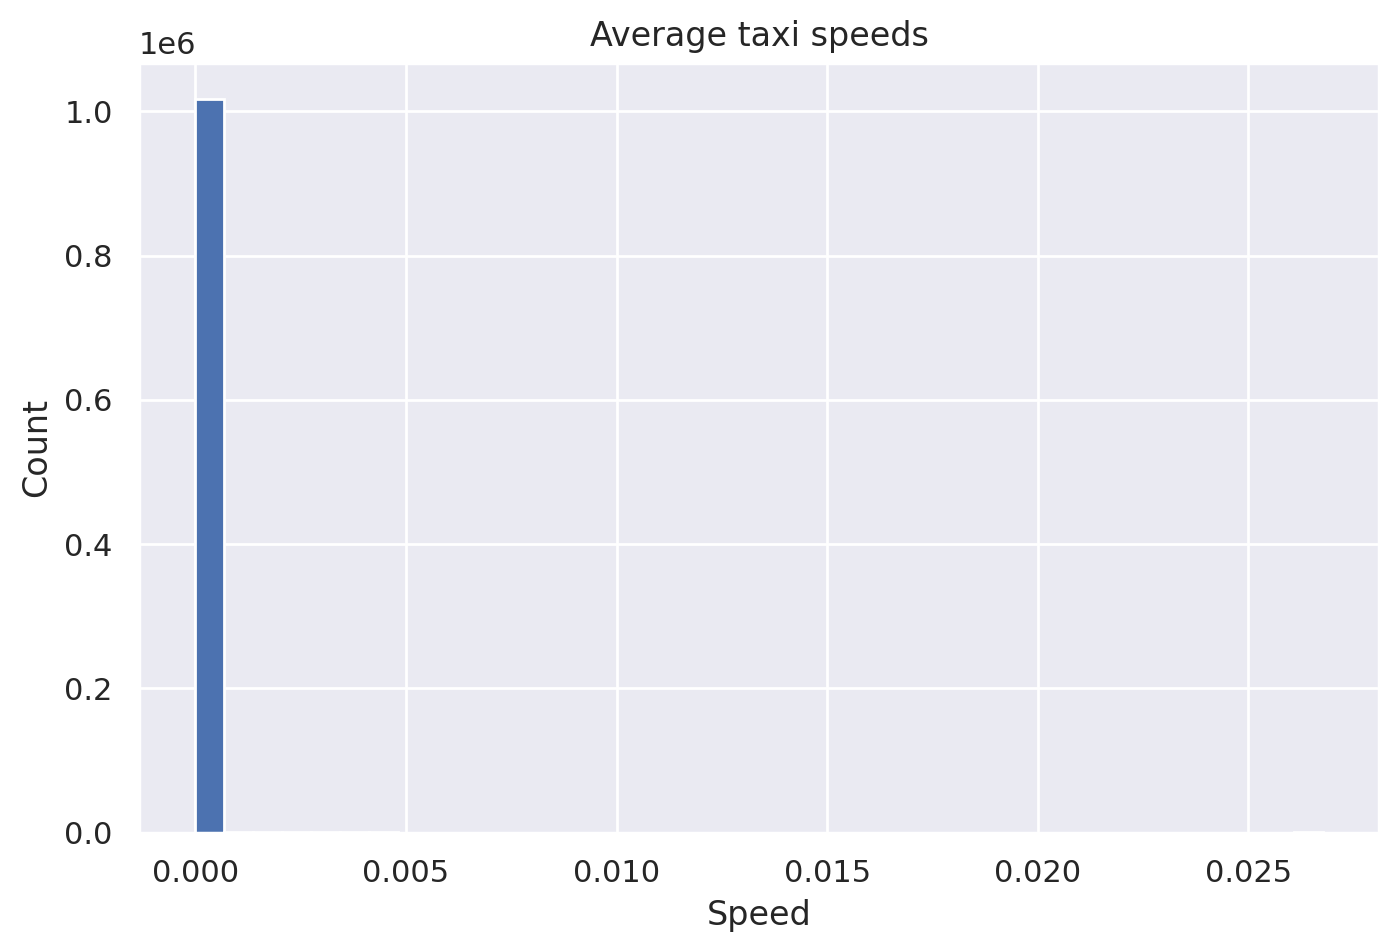

In [22]:
# B-b-but we dropped trip_duration, did we not..?
tmp = df5.loc[itr1].assign(trip_duration=np.expm1(df5["log_trip_duration"]))
tmp = tmp.assign(speed=tmp["haversine"] / tmp["trip_duration"])

plt.hist(tmp["speed"], bins="doane")
plt.xlabel("Speed")
plt.ylabel("Count")
plt.title("Average taxi speeds")
plt.show()

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

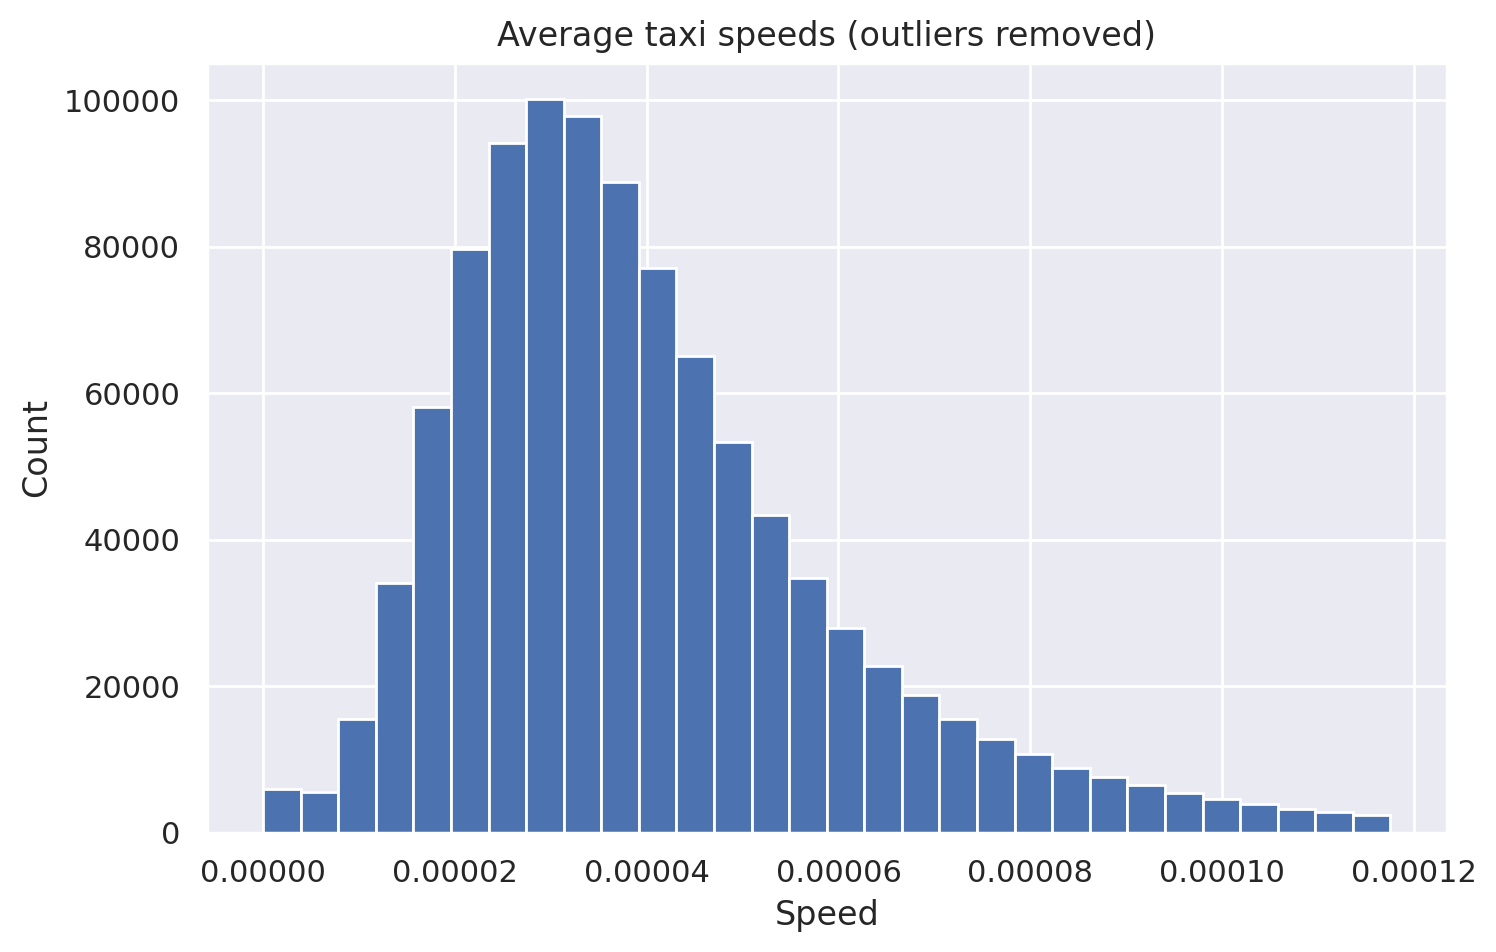

In [23]:
speed_th = np.quantile(tmp["speed"], 0.99)
plt.hist(tmp[tmp["speed"] < speed_th]["speed"], bins="doane")
plt.xlabel("Speed")
plt.ylabel("Count")
plt.title("Average taxi speeds (outliers removed)")
plt.show()

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

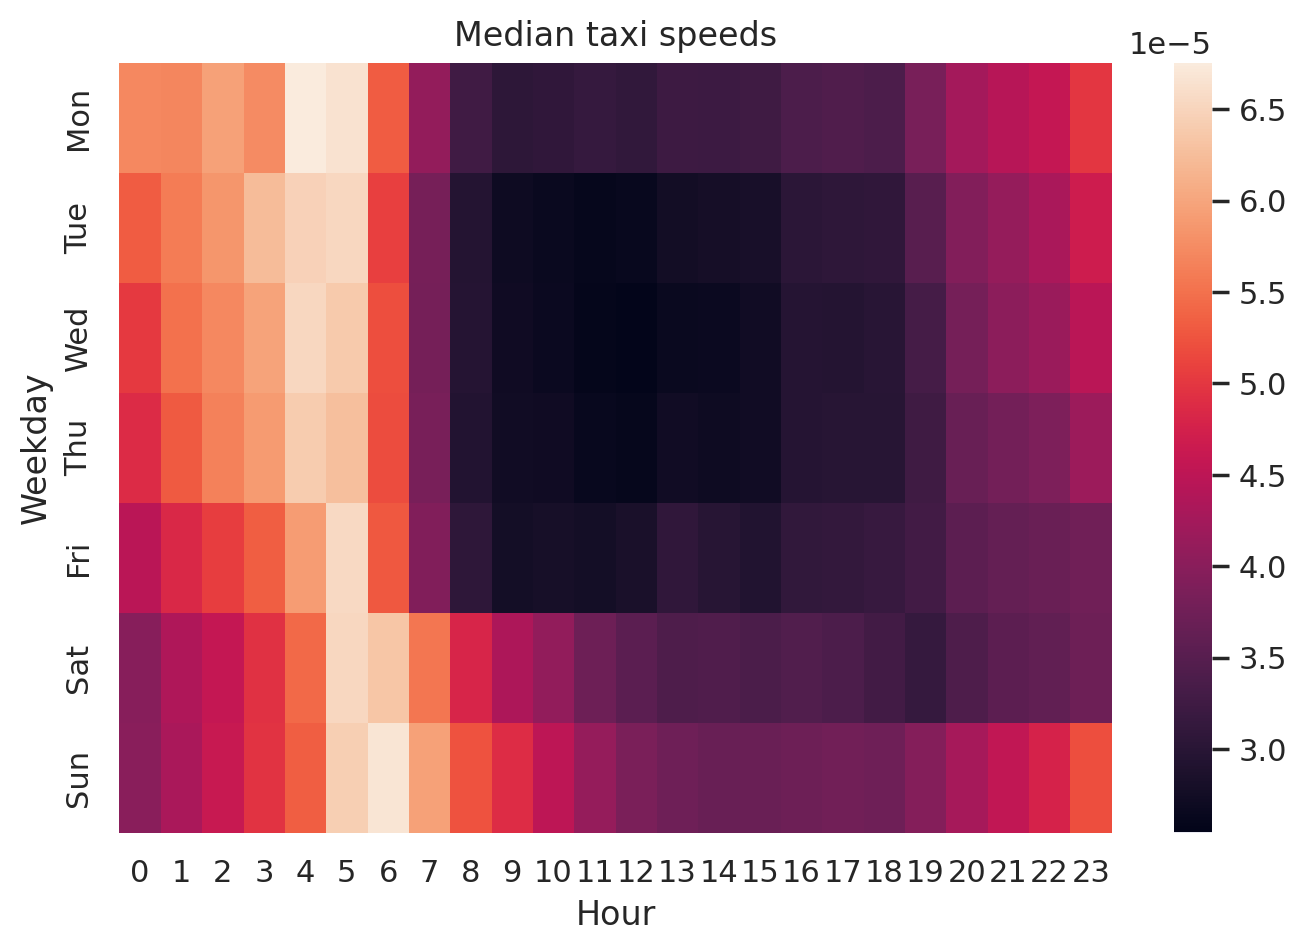

In [24]:
sns.heatmap(
    tmp
    .groupby(["weekday", "hour"])["speed"].median().unstack()
    .rename(index=lambda i: ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"][i])
    .rename_axis(index="Weekday", columns="Hour")
)
plt.title("Median taxi speeds")
plt.show()

del tmp

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

**Ответ**: значение скорости содержит информацию о целевой переменной &mdash; времени поездки.

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

**Ответ**: минимум с 8 по 18 часов в рабочие дни, максимум &mdash; с 4 по 5 часов в рабочие дни и с 5 по 6 часов в выходные.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [25]:
df6 = df5.assign(roads_busy=0, roads_free=0)
df6.loc[(df6["weekday"] < 5) & (df6["hour"] >= 8) & (df6["hour"] <= 18), "roads_busy"] = 1
df6.loc[(df6["weekday"] < 5) & (df6["hour"] >= 4) & (df6["hour"] <= 5), "roads_free"] = 1
df6.loc[(df6["weekday"] >= 5) & (df6["hour"] >= 5) & (df6["hour"] <= 6), "roads_free"] = 1
df6.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,month,weekday,day,hour,anomaly,haversine,log_haversine,roads_busy,roads_free
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,6.122493,3,0,74,17,0,0.017632,-4.038035,1,0
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,6.498282,6,6,164,0,0,0.020356,-3.894358,0,0
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,7.661527,1,1,19,11,0,0.059870,-2.815572,1,0
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,6.063785,4,2,97,19,0,0.013435,-4.309875,0,0
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,6.077642,3,5,86,13,0,0.010690,-4.538487,0,0


**Задание 8 (0.25 балла)**. Для каждого из замеченных вами выше 2-3 пунктов добавьте в выборку по два признака: 
- началась ли поездка в этом пункте
- закончилась ли поездка в этом пункте

Как вы думаете, почему эти признаки могут быть полезны? _&mdash; ответ был выше_

In [26]:
jfk_coords = (40.64659766289504, -73.79485458682255)
jfk_radius = 0.018
laguardia_coords = (40.775611954467195, -73.8733651721943)
laguardia_radius = 0.013

df7 = df6.assign(from_jfk=0, to_jfk=0, from_laguardia=0, to_laguardia=0)
df7.loc[haversine(df7["pickup_latitude"], df7["pickup_longitude"], *jfk_coords) < jfk_radius, "from_jfk"] = 1
df7.loc[haversine(df7["dropoff_latitude"], df7["dropoff_longitude"], *jfk_coords) < jfk_radius, "to_jfk"] = 1
df7.loc[haversine(df7["pickup_latitude"], df7["pickup_longitude"], *laguardia_coords) < laguardia_radius, "from_laguardia"] = 1
df7.loc[haversine(df7["dropoff_latitude"], df7["dropoff_longitude"], *laguardia_coords) < laguardia_radius, "to_laguardia"] = 1
df7.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,...,hour,anomaly,haversine,log_haversine,roads_busy,roads_free,from_jfk,to_jfk,from_laguardia,to_laguardia
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,6.122493,...,17,0,0.017632,-4.038035,1,0,0,0,0,0
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,6.498282,...,0,0,0.020356,-3.894358,0,0,0,0,0,0
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,7.661527,...,11,0,0.059870,-2.815572,1,0,0,0,0,0
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,6.063785,...,19,0,0.013435,-4.309875,0,0,0,0,0,0
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,6.077642,...,13,0,0.010690,-4.538487,0,0,0,0,0,0


Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

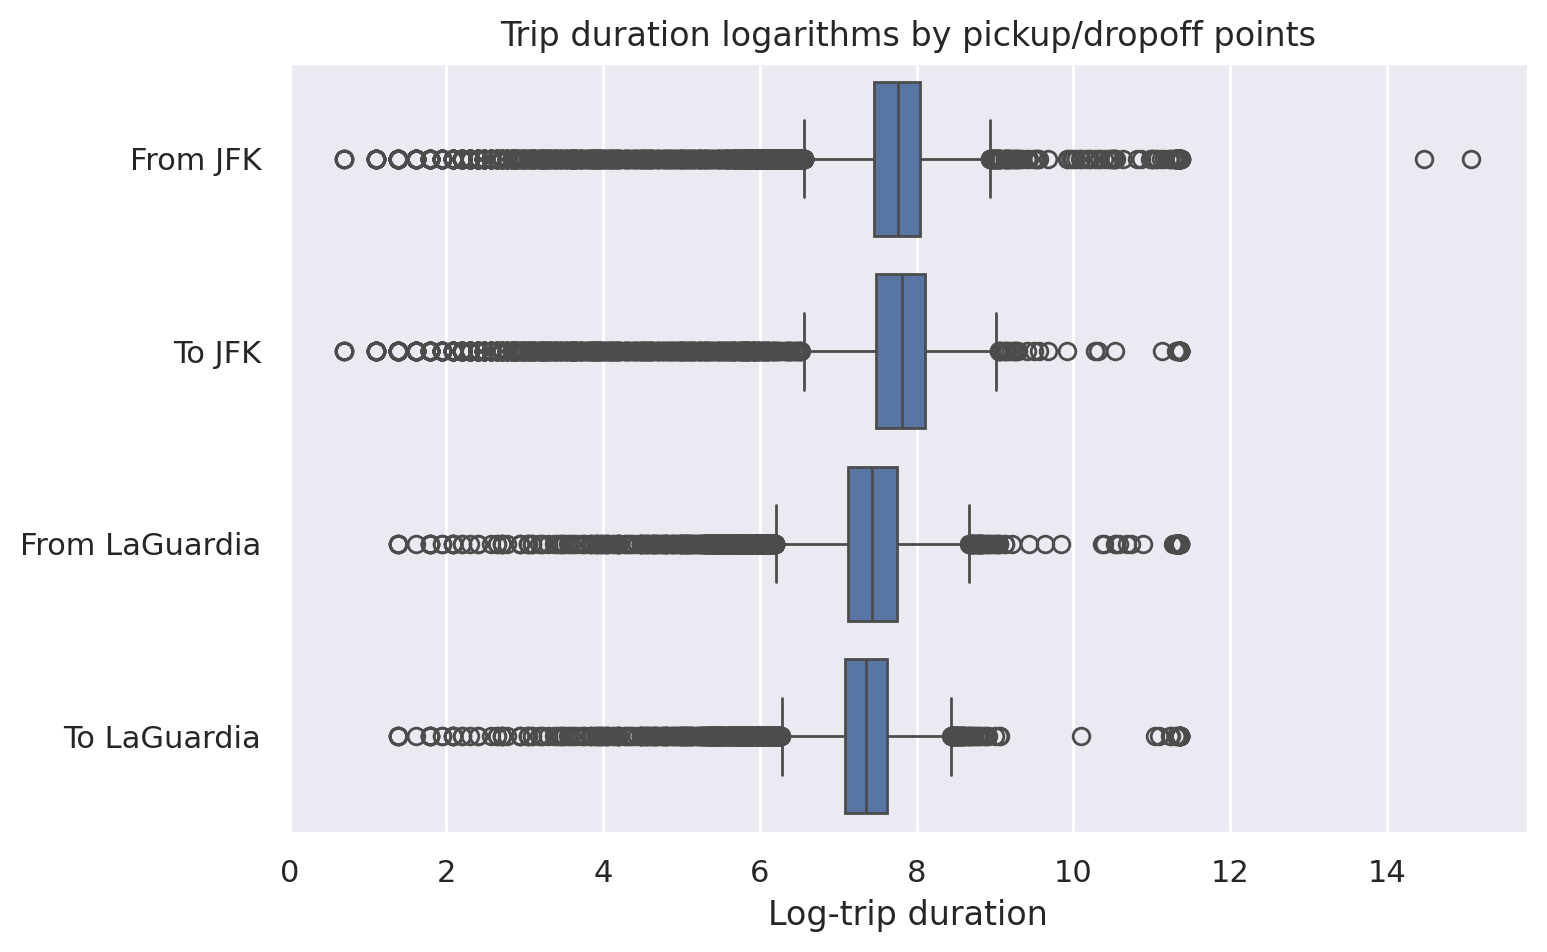

In [27]:
tmp = pd.concat([
    df7.loc[df7["from_jfk"] == 1].assign(tag="From JFK"),
    df7.loc[df7["to_jfk"] == 1].assign(tag="To JFK"),
    df7.loc[df7["from_laguardia"] == 1].assign(tag="From LaGuardia"),
    df7.loc[df7["to_laguardia"] == 1].assign(tag="To LaGuardia"),
], axis=0)
sns.boxplot(tmp, x="log_trip_duration", y="tag")
plt.xlabel("Log-trip duration")
plt.ylabel("")
plt.title("Trip duration logarithms by pickup/dropoff points")
plt.show()

del tmp

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

**Ответ**: думаю, что хоть сколько-то пользы в них будет.

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [28]:
from sklearn.base import BaseEstimator, TransformerMixin


# TransformerMixin implements fit_transform for you,
# applying your fit and transform consistently
    
class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, lat_1, lon_1, lat_2, lon_2, rows=5, cols=3):
        self.lats = np.linspace(min(lat_1, lat_2), max(lat_1, lat_2), rows + 1)
        self.lons = np.linspace(min(lon_1, lon_2), max(lon_1, lon_2), cols + 1)

    def show_map(self):
        map = folium.Map(location=(self.lats.mean(), self.lons.mean()))
        for lat in self.lats:
            folium.PolyLine([(lat, self.lons[0]), (lat, self.lons[-1])]).add_to(map)
        for lon in self.lons:
            folium.PolyLine([(self.lats[0], lon), (self.lats[-1], lon)]).add_to(map)
        return map
    
    def fit(self, X=None, y=None):
        return self

    def transform_points(self, lat, lon):
        lat_cell = np.searchsorted(self.lats, lat)
        lon_cell = np.searchsorted(self.lons, lon)
        cell = (lat_cell - 1) * (len(self.lons) - 1) + (lon_cell - 1)
        cell[(lat_cell < 1) | (lat_cell >= len(self.lats))] = -1
        cell[(lon_cell < 1) | (lon_cell >= len(self.lons))] = -1
        return cell

    def transform(self, X, y=None):
        return X.assign(
            pickup_cell=self.transform_points(X["pickup_latitude"], X["pickup_longitude"]),
            dropoff_cell=self.transform_points(X["dropoff_latitude"], X["dropoff_longitude"]),
        )


grid_p1 = (40.80106478027712, -74.02446586211599)
grid_p2 = (40.706049810697245, -73.93357514477022)

df8 = MapGridTransformer(*grid_p1, *grid_p2).fit_transform(df7)
df8.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,...,haversine,log_haversine,roads_busy,roads_free,from_jfk,to_jfk,from_laguardia,to_laguardia,pickup_cell,dropoff_cell
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,6.122493,...,0.017632,-4.038035,1,0,0,0,0,0,10,10
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,6.498282,...,0.020356,-3.894358,0,0,0,0,0,0,4,3
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,7.661527,...,0.059870,-2.815572,1,0,0,0,0,0,10,0
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,6.063785,...,0.013435,-4.309875,0,0,0,0,0,0,0,0
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,6.077642,...,0.010690,-4.538487,0,0,0,0,0,0,13,13


In [29]:
MapGridTransformer(*grid_p1, *grid_p2).show_map()

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [30]:
tmp = encode_and_scale(
    df8,
    [
        "month", "weekday", "hour", "anomaly",
        "roads_busy", "roads_free",
        "from_jfk", "to_jfk", "from_laguardia", "to_laguardia",
        "pickup_cell", "dropoff_cell",
    ],
    ["day", "log_haversine"],
)
model = sklearn.linear_model.Ridge().fit(tmp, df8["log_trip_duration"])
print(rmsle(df8["log_trip_duration"], model.predict(tmp)))

del tmp, model

0.45529030398706777


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

**Ответ**:
- `vendor_id` &mdash; возможно, что от вендора зависит регион, где оперирует то или иное такси
- `passenger_count` &mdash; возможно, что в группе люди чаще ездят на дальние расстояния в целях экономии денег
- `store_and_fwd_flag` &mdash; наличие флага означает отсутствие подключения к интернету у такси, поэтому может быть,
  что это происходит преимущественно в отдаленных от цивилизации местах

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [31]:
df8[["vendor_id", "passenger_count", "store_and_fwd_flag"]].nunique().rename("Unique value count")

vendor_id             2
passenger_count       9
store_and_fwd_flag    2
Name: Unique value count, dtype: int64

Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

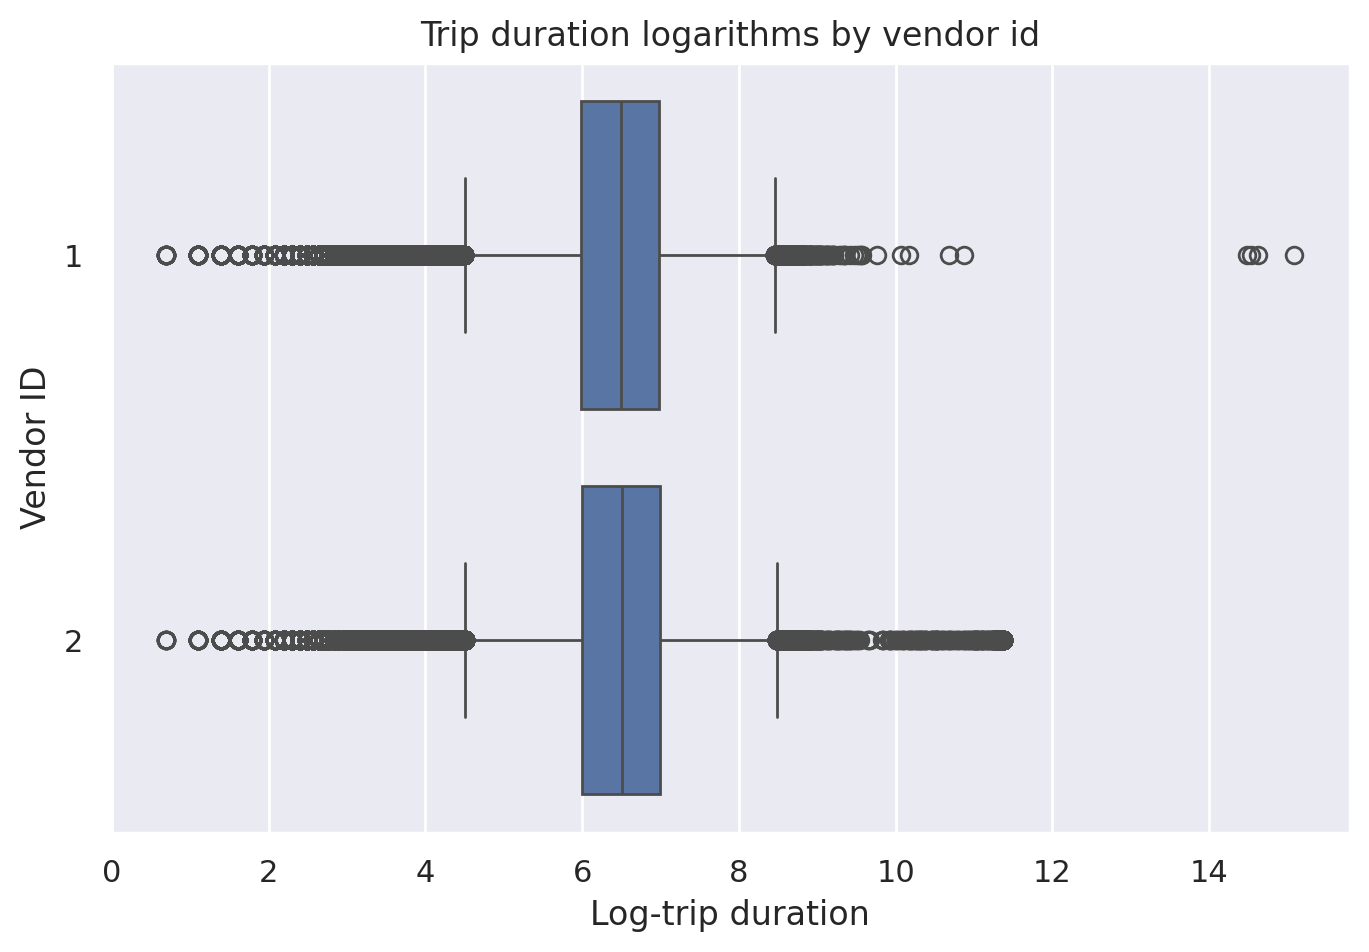

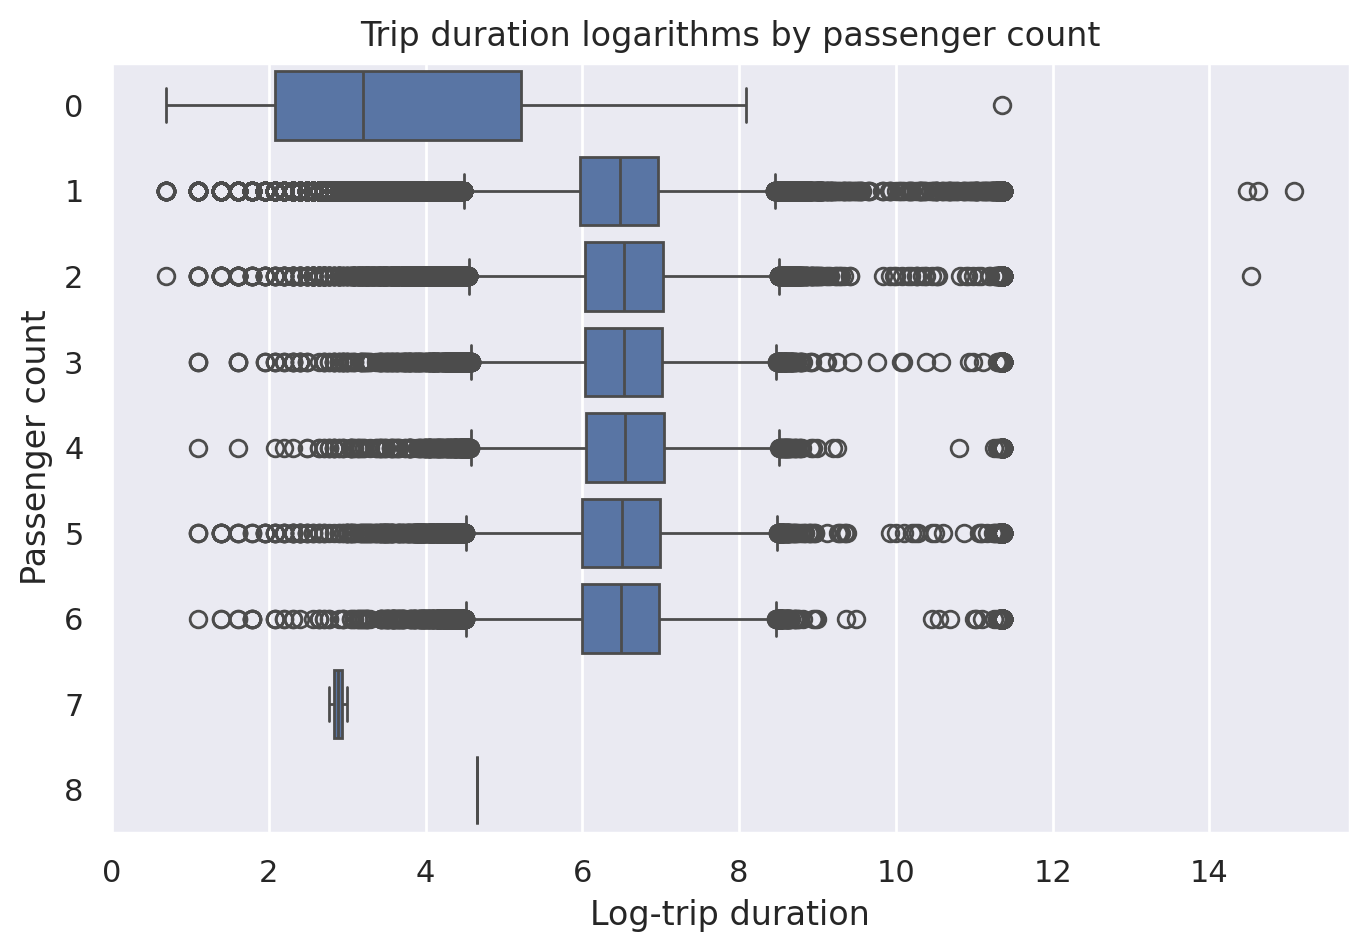

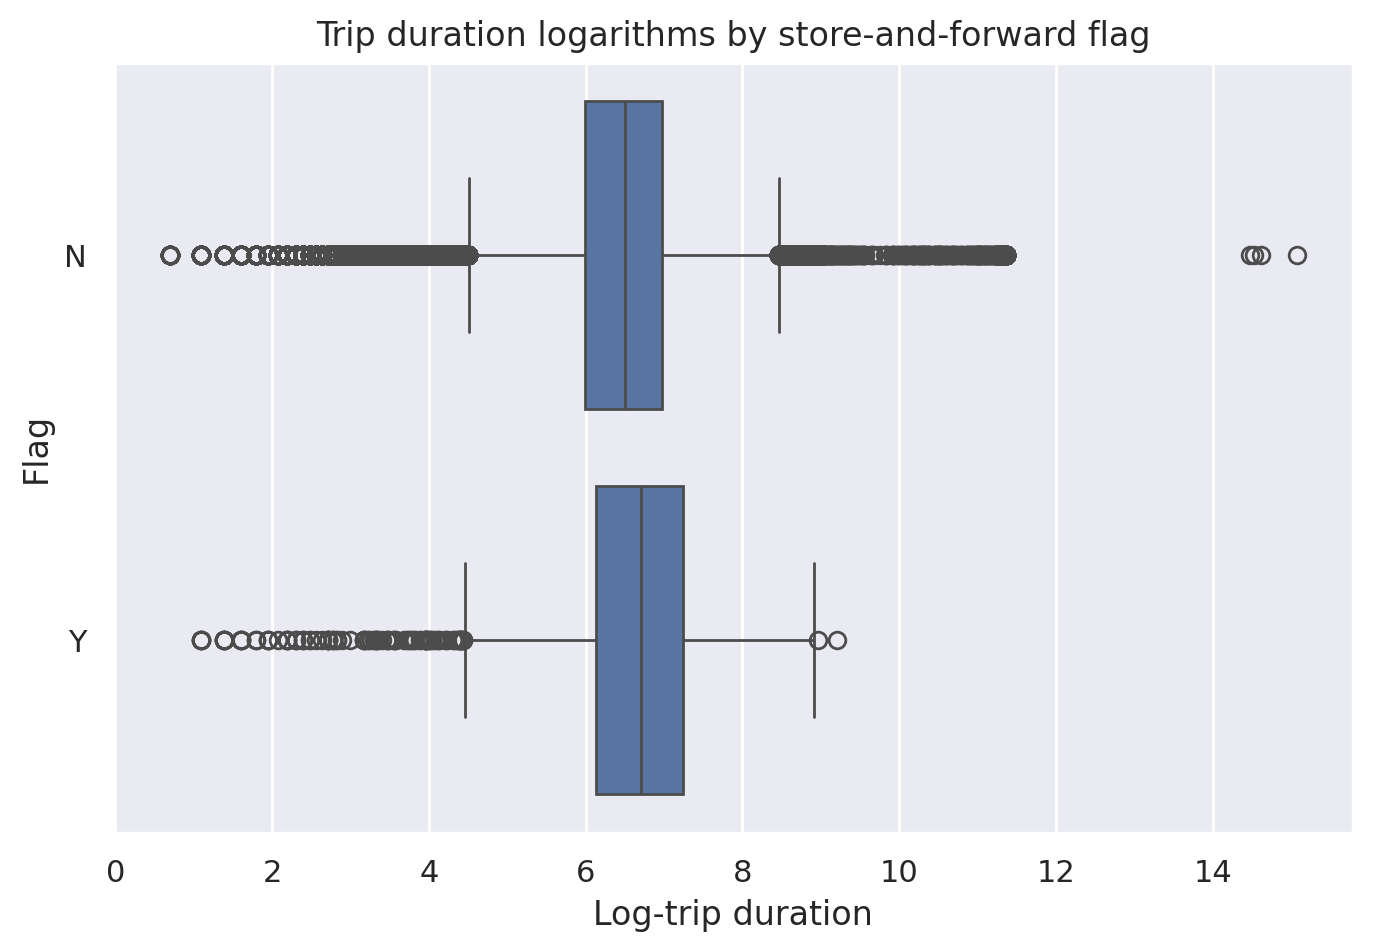

In [32]:
sns.boxplot(df8, x="log_trip_duration", y="vendor_id", orient="h")
plt.xlabel("Log-trip duration")
plt.ylabel("Vendor ID")
plt.title("Trip duration logarithms by vendor id")
plt.show()

sns.boxplot(df8, x="log_trip_duration", y="passenger_count", orient="h")
plt.xlabel("Log-trip duration")
plt.ylabel("Passenger count")
plt.title("Trip duration logarithms by passenger count")
plt.show()

sns.boxplot(df8, x="log_trip_duration", y="store_and_fwd_flag", orient="h")
plt.xlabel("Log-trip duration")
plt.ylabel("Flag")
plt.title("Trip duration logarithms by store-and-forward flag")
plt.show()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$ _&mdash; зачем?_

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Ответ**: нет.

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [33]:
tmp = encode_and_scale(
    df8,
    [
        "month", "weekday", "hour", "anomaly",
        "roads_busy", "roads_free",
        "from_jfk", "to_jfk", "from_laguardia", "to_laguardia",
        "pickup_cell", "dropoff_cell",
        "vendor_id", "passenger_count", "store_and_fwd_flag",
    ],
    ["day", "log_haversine"],
)
model = sklearn.linear_model.Ridge().fit(tmp, df8["log_trip_duration"])
print(rmsle(df8["log_trip_duration"], model.predict(tmp)))

del tmp, model

0.45506183356667124


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

_&mdash; RMSLE лучше предыдущего всего на ~0.00023, поэтому далее эти признаки использовать не будем_

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты (выбросы, или outliers): с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите __обучающую выборку__ от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

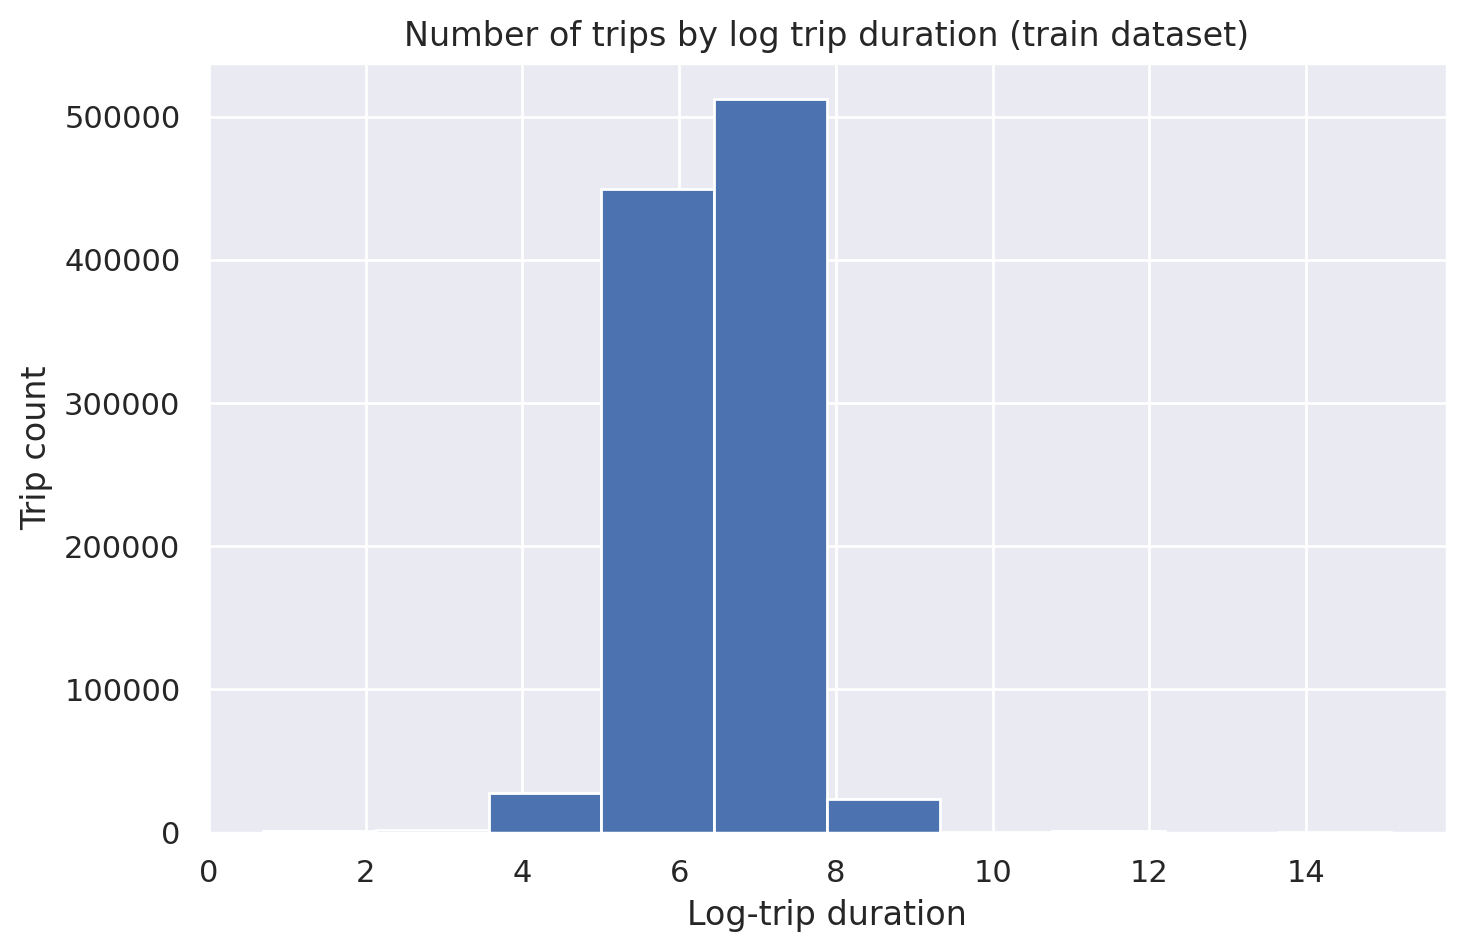

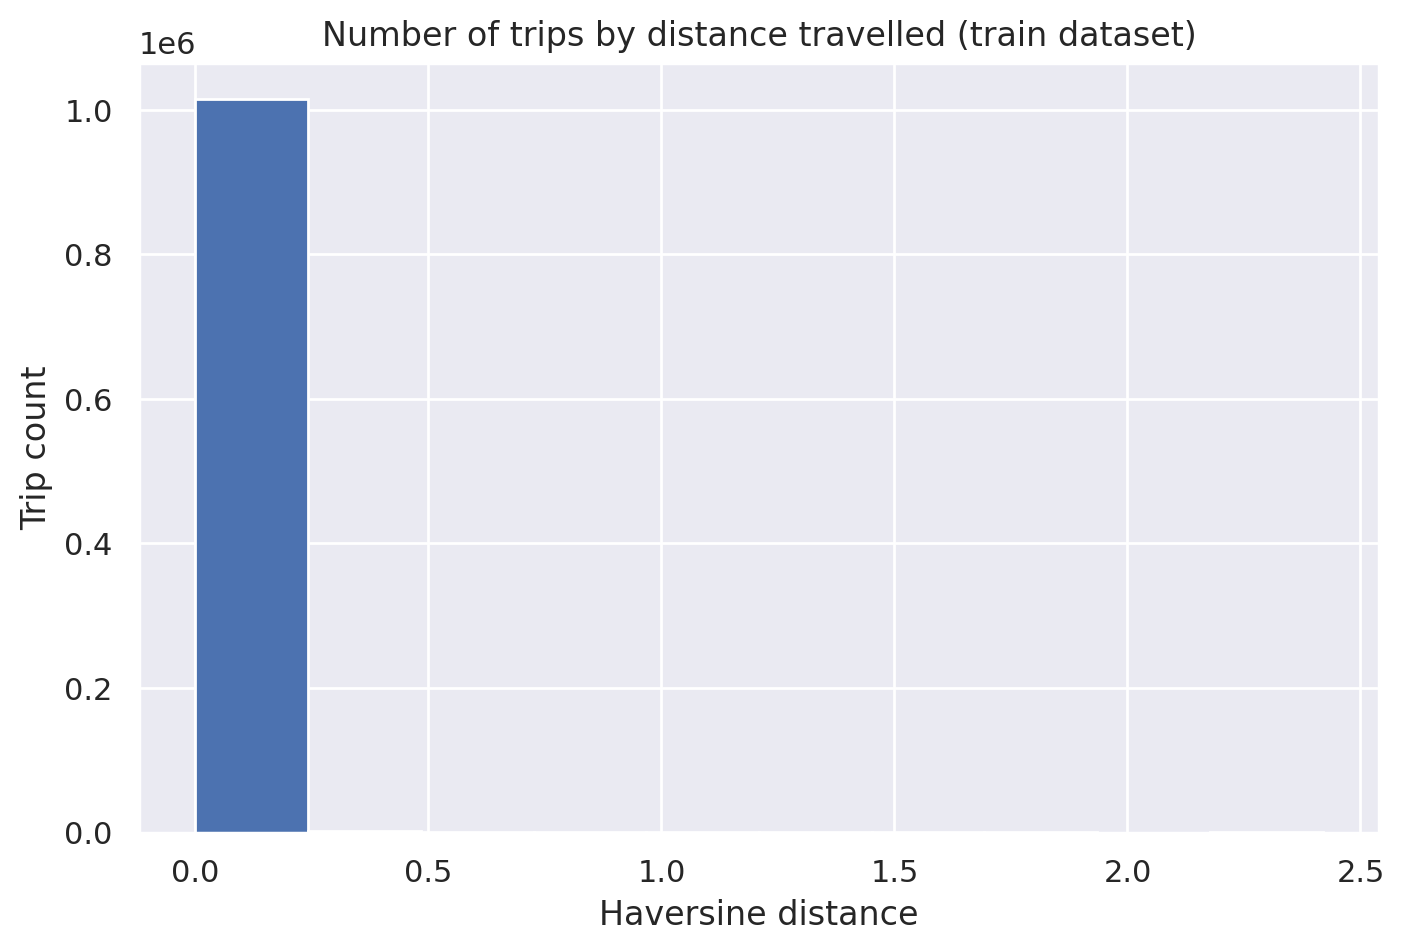

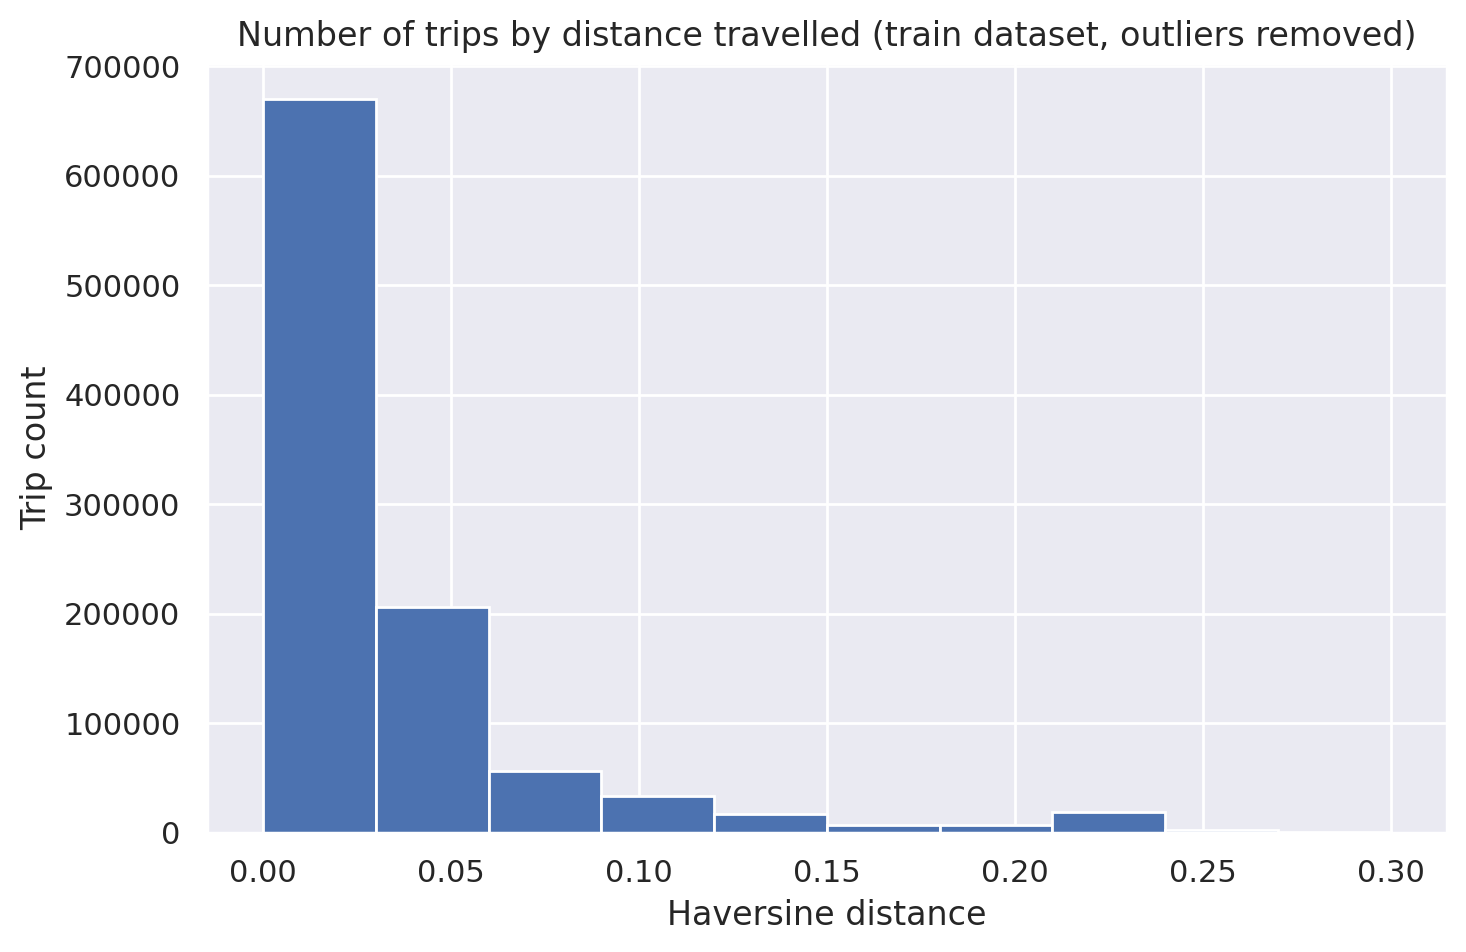

Dropped 6847 trips from the train dataset


In [34]:
df8_train = df8.loc[itr1]

plt.hist(df8_train["log_trip_duration"])
plt.xlabel("Log-trip duration")
plt.ylabel("Trip count")
plt.title("Number of trips by log trip duration (train dataset)")
plt.show()

plt.hist(df8_train["haversine"])
plt.xlabel("Haversine distance")
plt.ylabel("Trip count")
plt.title("Number of trips by distance travelled (train dataset)")
plt.show()

plt.hist(df8_train["haversine"][df8_train["haversine"] < 0.3])
plt.xlabel("Haversine distance")
plt.ylabel("Trip count")
plt.title("Number of trips by distance travelled (train dataset, outliers removed)")
plt.show()

itr2 = (
    itr1
    .intersection(df8_train[(df8_train["log_trip_duration"] > 4.0) & (df8_train["log_trip_duration"] < 9.0)].index)
    .intersection(df8_train[df8_train["haversine"] < 0.25].index)
)
ite2 = ite1
del df8_train

print(f"Dropped {len(itr1) - len(itr2)} trips from the train dataset")

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Для каждого категориального признака объедините действительно редкие категории в одну, если такие имеются (т.е. если категории действительно редкие). 

In [35]:
merge_lists = {x: [] for x in [
    "month", "weekday", "hour", "anomaly",
    "roads_busy", "roads_free",
    "from_jfk", "to_jfk", "from_laguardia", "to_laguardia",
    "pickup_cell", "dropoff_cell",
]}
merge_th = 0.035  # merged categories must make up in total no more than (merge_th * 100)% of all data points
merge_repl = 1000  # replacement category (all categorical features are integers)

for feature, merge_list in merge_lists.items():
    counts = df8[feature].value_counts().sort_values()
    total = counts.sum()
    cumsum = 0
    for category, count in counts.items():
        cumsum += count
        if (cumsum / total) > merge_th:
            break
        merge_list.append(category)

df9 = df8.copy()
for feature, merge_list in merge_lists.items():
    if len(merge_list) < 2:
        continue
    mask = df8[feature].isin(merge_list)
    print(f"Merging '{feature}' categories {merge_list} (trips affected: {mask.sum()})")
    df9.loc[mask, feature] = merge_repl

Merging 'hour' categories [5, 4] (trips affected: 30630)
Merging 'pickup_cell' categories [12, 5, 9, 2, 8] (trips affected: 28888)
Merging 'dropoff_cell' categories [12, 5, 9, 2, 8] (trips affected: 42634)


Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [36]:
df9_train = df9.loc[itr2]
df9_test = df9.loc[ite2]
categorical = [
    "month", "weekday", "hour", "anomaly",
    "roads_busy", "roads_free",
    "from_jfk", "to_jfk", "from_laguardia", "to_laguardia",
    "pickup_cell", "dropoff_cell",
]
numeric = ["day", "log_haversine"]
encoder = sklearn.preprocessing.OneHotEncoder(drop="first", sparse_output=False).fit(df9[categorical])
tmp, _, scaler = encode_and_scale(df9_train, categorical, numeric, encoder=encoder, return_transformers=True)
model = sklearn.linear_model.Ridge().fit(tmp, df9_train["log_trip_duration"])
tmp = encode_and_scale(df9_test, categorical, numeric, encoder=encoder, scaler=scaler)
print(rmsle(df9_test["log_trip_duration"], model.predict(tmp)))

del tmp, model, df9_train, df9_test, encoder, scaler

0.4552650942389136


**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [37]:
categorical = [
    "month", "weekday", "hour", "anomaly",
    "roads_busy", "roads_free",
    "from_jfk", "to_jfk", "from_laguardia", "to_laguardia",
    "pickup_cell", "dropoff_cell",
]
numeric = ["day", "log_haversine"]
encoder = sklearn.preprocessing.OneHotEncoder(drop="first").fit(df9[categorical])
print(f"Before encoding: {len(categorical) + len(numeric)} features")
print(f"After encoding: {len(encoder.get_feature_names_out()) + len(numeric)} features")

Before encoding: 14 features
After encoding: 64 features


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше? _&mdash; Ridge_

In [38]:
df9_train = df9.loc[itr2]
df9_test = df9.loc[ite2]
categorical = [
    "month", "weekday", "hour", "anomaly",
    "roads_busy", "roads_free",
    "from_jfk", "to_jfk", "from_laguardia", "to_laguardia",
    "pickup_cell", "dropoff_cell",
]
numeric = ["day", "log_haversine"]
encoder = sklearn.preprocessing.OneHotEncoder(drop="first", sparse_output=False).fit(df9[categorical])
tmp, _, scaler = encode_and_scale(df9_train, categorical, numeric, encoder=encoder, return_transformers=True)
model = sklearn.linear_model.Lasso().fit(tmp, df9_train["log_trip_duration"])
tmp = encode_and_scale(df9_test, categorical, numeric, encoder=encoder, scaler=scaler)
print(rmsle(df9_test["log_trip_duration"], model.predict(tmp)))

del tmp, model, df9_train, df9_test, encoder, scaler

0.7847365911277147


Разбейте _обучающую выборку_ на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [39]:
df9_train, df9_valid = sklearn.model_selection.train_test_split(df9.loc[itr2], train_size=0.8, test_size=0.2, random_state=42)
df9_test = df9.loc[ite2]
categorical = [
    "month", "weekday", "hour", "anomaly",
    "roads_busy", "roads_free",
    "from_jfk", "to_jfk", "from_laguardia", "to_laguardia",
    "pickup_cell", "dropoff_cell",
]
numeric = ["day", "log_haversine"]
encoder = sklearn.preprocessing.OneHotEncoder(drop="first", sparse_output=False).fit(df9[categorical])
tmp_train, _, scaler = encode_and_scale(df9_train, categorical, numeric, encoder=encoder, return_transformers=True)
tmp_valid = encode_and_scale(df9_valid, categorical, numeric, encoder=encoder, scaler=scaler)
tmp_test = encode_and_scale(df9_test, categorical, numeric, encoder=encoder, scaler=scaler)

ridge_results = []
for alpha in np.logspace(-4.0, 3.5, 25):
    model = sklearn.linear_model.Ridge(alpha=alpha).fit(tmp_train, df9_train["log_trip_duration"])
    result = rmsle(df9_valid["log_trip_duration"], model.predict(tmp_valid))
    ridge_results.append((result, alpha))
    print(f"Ridge(a={alpha:.03f}): {result}")

lasso_results = []
for alpha in np.logspace(-4.0, 0.22, 25):
    model = sklearn.linear_model.Lasso(alpha=alpha).fit(tmp_train, df9_train["log_trip_duration"])
    result = rmsle(df9_valid["log_trip_duration"], model.predict(tmp_valid))
    lasso_results.append((result, alpha, (model.coef_ == 0.0).sum()))
    print(f"Lasso(a={alpha:.03f}): {result}")

print()

best_alpha = min(ridge_results)[1]
model = sklearn.linear_model.Ridge(alpha=best_alpha).fit(tmp_train, df9_train["log_trip_duration"])
result = rmsle(df9_test["log_trip_duration"], model.predict(tmp_test))
print(f"Best ridge regression result: {result} on test dataset with a={best_alpha}")

best_alpha = min(lasso_results)[1]
model = sklearn.linear_model.Lasso(alpha=best_alpha).fit(tmp_train, df9_train["log_trip_duration"])
result = rmsle(df9_test["log_trip_duration"], model.predict(tmp_test))
print(f"Best lasso regression result: {result} on test dataset with a={best_alpha}")

del tmp_train, tmp_valid, tmp_test, model, df9_train, df9_valid, df9_test, encoder, scaler

Ridge(a=0.000): 0.40926525885573667
Ridge(a=0.000): 0.40926525885006293
Ridge(a=0.000): 0.4092652588384118
Ridge(a=0.001): 0.40926525881448594
Ridge(a=0.002): 0.4092652587653539
Ridge(a=0.004): 0.4092652586644605
Ridge(a=0.007): 0.4092652584572764
Ridge(a=0.015): 0.40926525803183067
Ridge(a=0.032): 0.4092652571582179
Ridge(a=0.065): 0.40926525536444613
Ridge(a=0.133): 0.4092652516817932
Ridge(a=0.274): 0.4092652441231771
Ridge(a=0.562): 0.40926522861740217
Ridge(a=1.155): 0.4092651968434397
Ridge(a=2.371): 0.4092651318789699
Ridge(a=4.870): 0.40926499966563656
Ridge(a=10.000): 0.40926473314571155
Ridge(a=20.535): 0.4092642064607141
Ridge(a=42.170): 0.40926320859514614
Ridge(a=86.596): 0.4092614867309001
Ridge(a=177.828): 0.4092591467613068
Ridge(a=365.174): 0.4092582666231276
Ridge(a=749.894): 0.40926784322699084
Ridge(a=1539.927): 0.4093186945223367
Ridge(a=3162.278): 0.4095088926052346
Lasso(a=0.000): 0.40930422334131983
Lasso(a=0.000): 0.40936202548494155
Lasso(a=0.000): 0.409442750

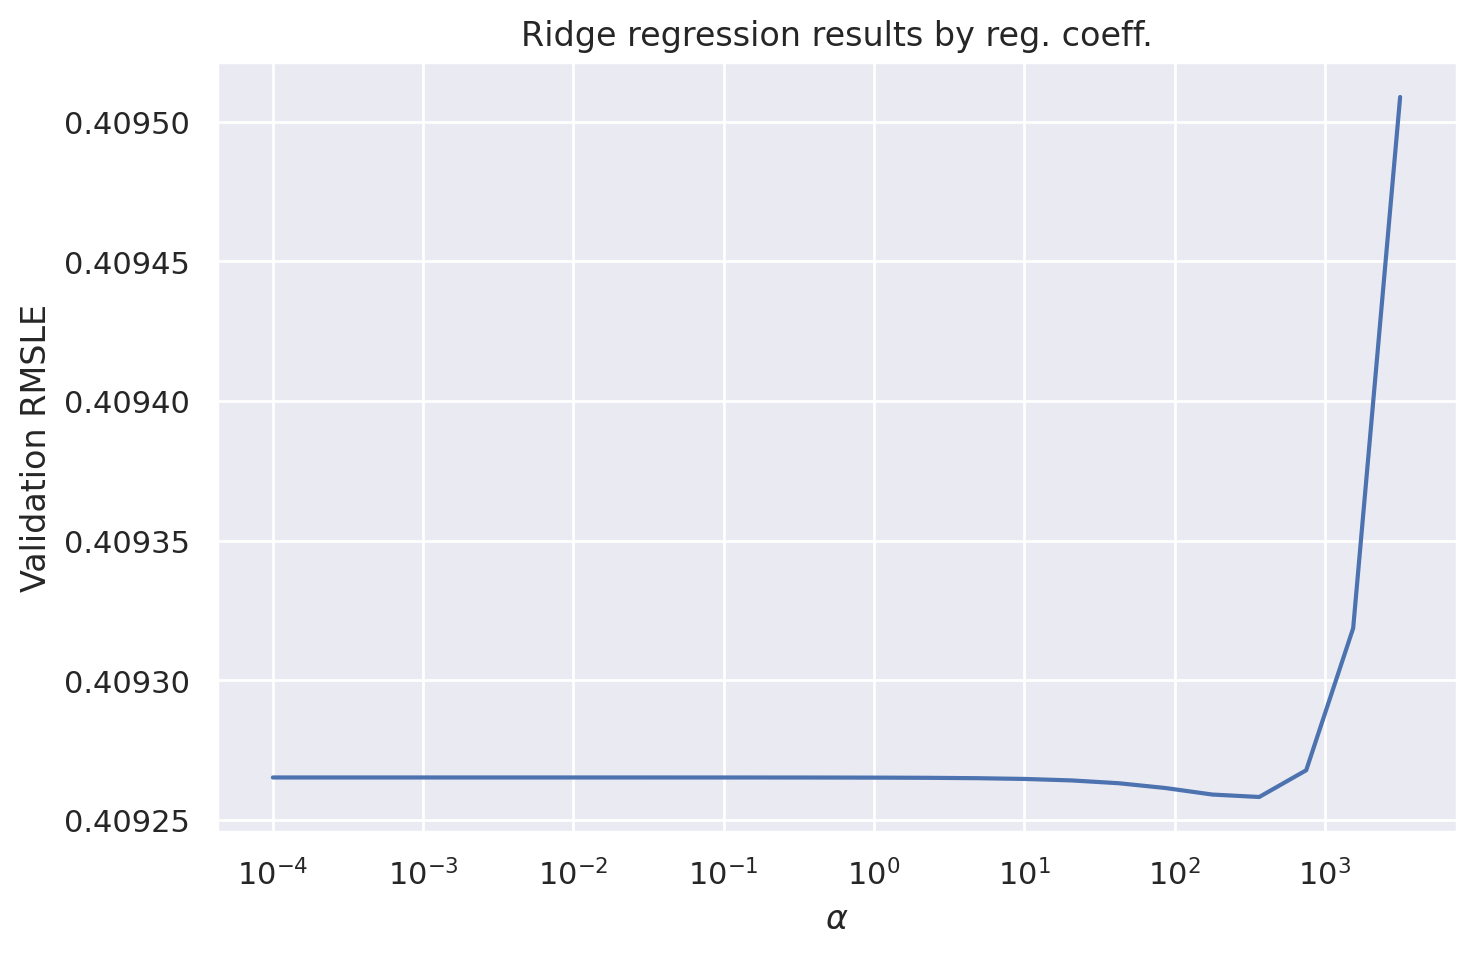

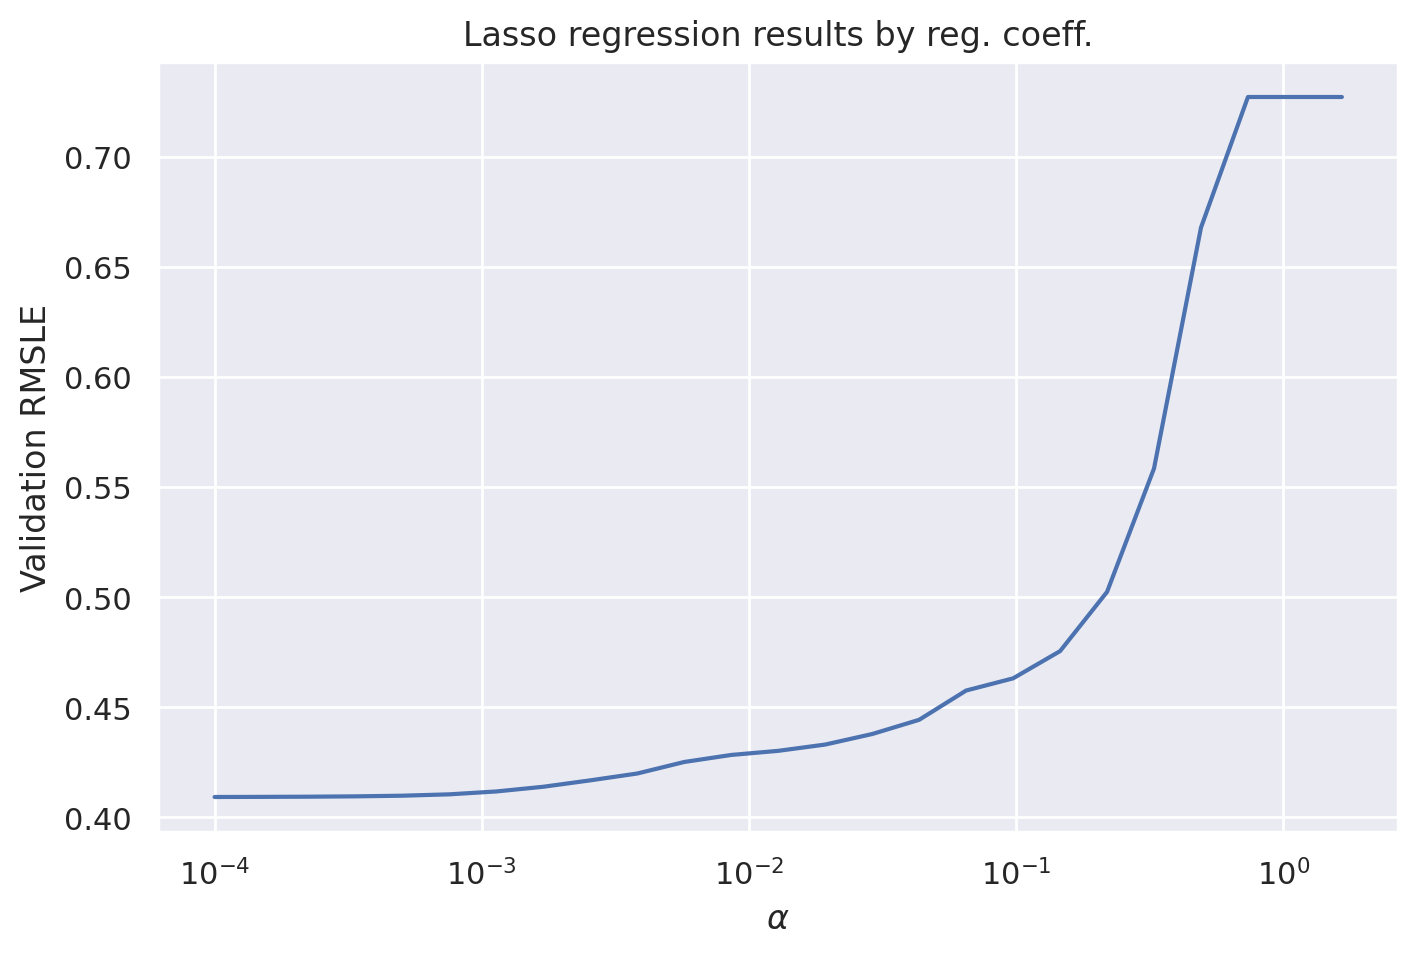

In [40]:
y, x = zip(*ridge_results)
plt.plot(x, y)
plt.xscale("log")
plt.xlabel("$\\alpha$")
plt.ylabel("Validation RMSLE")
plt.title("Ridge regression results by reg. coeff.")
plt.show()

y, x, _ = zip(*lasso_results)
plt.plot(x, y)
plt.xscale("log")
plt.xlabel("$\\alpha$")
plt.ylabel("Validation RMSLE")
plt.title("Lasso regression results by reg. coeff.")
plt.show()

Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков? _&mdash; RMSLE больше минимального на ~0.0076 на валидационной выборке_

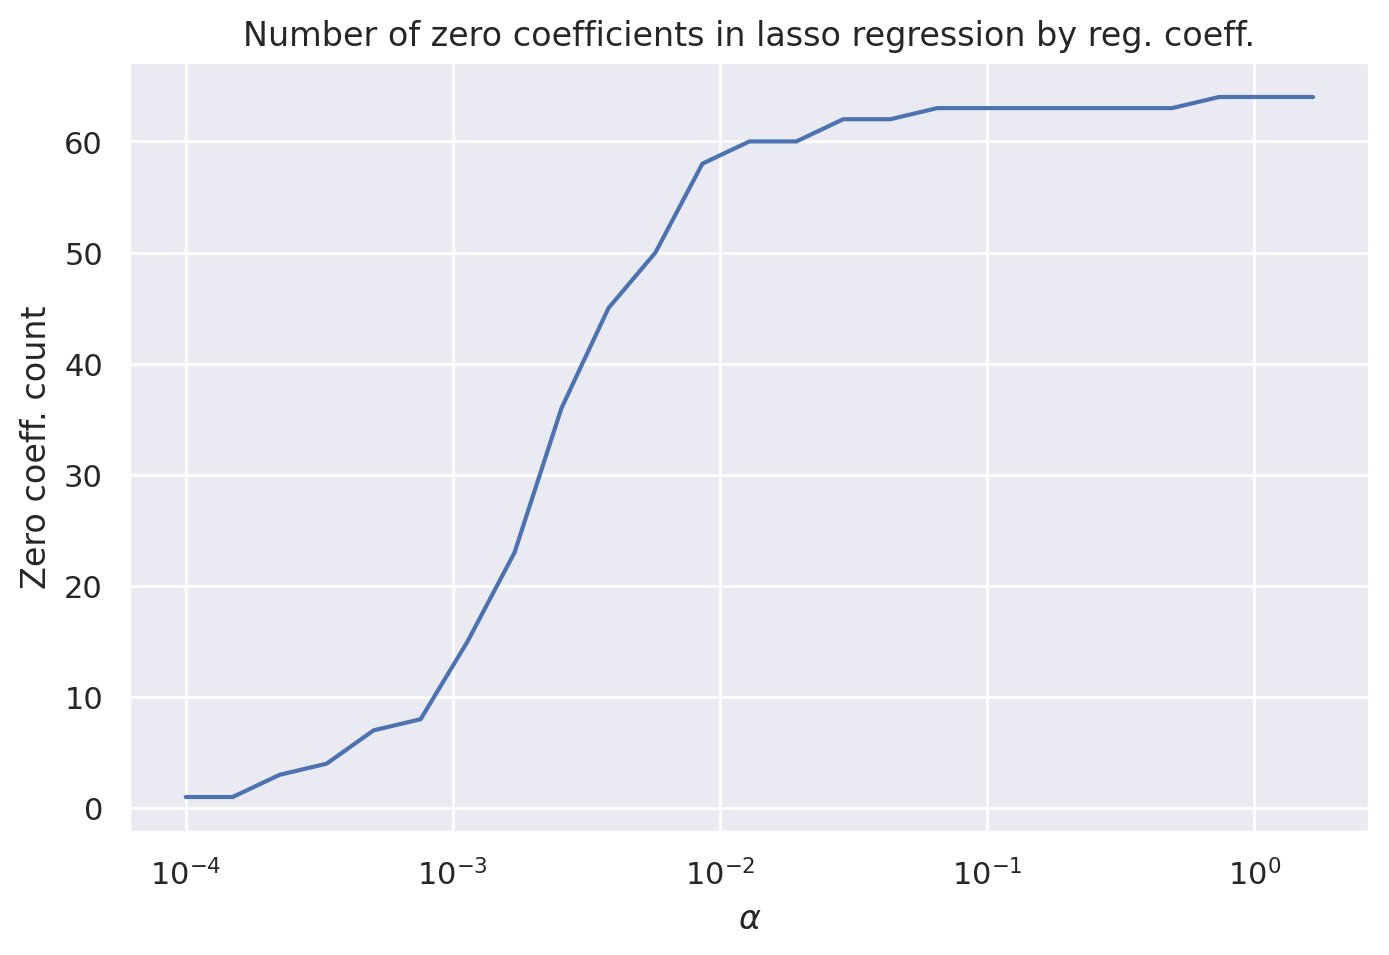

In [41]:
_, x, y = zip(*lasso_results)
plt.plot(x, y)
plt.xscale("log")
plt.xlabel("$\\alpha$")
plt.ylabel("Zero coeff. count")
plt.title("Number of zero coefficients in lasso regression by reg. coeff.")
plt.show()

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

**Ответ**: признак может быть полезен, т. к. он содержит информацию о маршруте в целом; самостоятельно эту информацию модель вытащить не может, потому что это невозможно сделать одной линейной трансформацией.

In [42]:
df10 = df9.assign(route=-1)
endpoints = list(df10.groupby(["pickup_cell", "dropoff_cell"]).size().sort_values(ascending=False).index)[:100]
for i, (pickup, dropoff) in enumerate(endpoints):
    df10.loc[(df10["pickup_cell"] == pickup) & (df10["dropoff_cell"] == dropoff), "route"] = i
df10.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,...,log_haversine,roads_busy,roads_free,from_jfk,to_jfk,from_laguardia,to_laguardia,pickup_cell,dropoff_cell,route
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,6.122493,...,-4.038035,1,0,0,0,0,0,10,10,9
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,6.498282,...,-3.894358,0,0,0,0,0,0,4,3,19
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,7.661527,...,-2.815572,1,0,0,0,0,0,10,0,88
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,6.063785,...,-4.309875,0,0,0,0,0,0,0,0,27
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,6.077642,...,-4.538487,0,0,0,0,0,0,13,13,33


Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [43]:
df10_train = df10.loc[itr2]
df10_test = df10.loc[ite2]
categorical = [
    "month", "weekday", "hour", "anomaly",
    "roads_busy", "roads_free",
    "from_jfk", "to_jfk", "from_laguardia", "to_laguardia",
    "pickup_cell", "dropoff_cell", "route",
]
numeric = ["day", "log_haversine"]
encoder = sklearn.preprocessing.OneHotEncoder(drop="first", sparse_output=False).fit(df10[categorical])
tmp, _, scaler = encode_and_scale(df10_train, categorical, numeric, encoder=encoder, return_transformers=True)
model = sklearn.linear_model.Ridge(alpha=365.1741272548377).fit(tmp, df10_train["log_trip_duration"])
tmp = encode_and_scale(df10_test, categorical, numeric, encoder=encoder, scaler=scaler)
print(rmsle(df10_test["log_trip_duration"], model.predict(tmp)))

del tmp, model, df10_train, df10_test, encoder, scaler

0.4489709958422713


**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут). 

In [44]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [45]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 17 (бонус, 2 балла)**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. За улучшение функционала ошибки на каждые 0.005 на тестовой выборке будет даваться 0.5 бонусных балла. Можно получить до 2 бонусных баллов за это задание.

In [46]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.